
PROJECT DESCRIPTION

The objective of this project is to construct a machine learning pipeline aimed at predicting the attrition rate of IBM services customers.



HYPOTHESIS

Analyzing the impact of Monthly Charges on the Customer Churn rate

Null Hypothesis: There is no sigificant relationship between Monthly Charges and Customer Churn rate

Alternate Hypothesis: There is a significant impact of Monthly Charges on the Customer Churn rate

ANALYTICAL QUESTIONS
1. Is there a significant difference in churn rates between different demographic groups, such as gender, senior citizens, customers with partners, and those with dependents?
2. Do customers subscribing to additional services (e.g., online security, device protection) exhibit different churn behavior compared to those who do not?
3. What is the impact of different types of contracts (month-to-month, one year, two years) on customer churn rates? Are customers with longer-term contracts more loyal?
4. Do different payment methods have an influence on customer churn rates?


DATA UNDERSTANDING

Import all the necessary packages

In [680]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dotenv import dotenv_values
import plotly.express as px
import seaborn as sns
import pyodbc
import warnings
warnings.filterwarnings('ignore')
import os
import pyxlsx
import pyxlsb
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler,MinMaxScaler,RobustScaler
from sklearn.preprocessing import OneHotEncoder,LabelEncoder,OrdinalEncoder
from sklearn.preprocessing import FunctionTransformer,PowerTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score,auc,roc_curve
from scipy.stats import ttest_ind
import joblib


LOAD THE DATASET

In [681]:
# Create an environment variable and connect the database

environment_variable = dotenv_values('.env')

server_name = environment_variable.get('server')
username = environment_variable.get('user')
password = environment_variable.get('password')
database_name = environment_variable.get('database')

connection_string = f'DRIVER={{SQL Server}};SERVER={server_name};PWD={password};DATABASE={database_name};UID={username}'

connection = pyodbc.connect(connection_string)

In [682]:
# Load the first dataset from the database
query = 'SELECT * FROM dbo.LP2_Telco_churn_first_3000'
df1 = pd.read_sql(query, connection)
df1.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,False,True,False,1,False,None,DSL,False,True,False,False,False,False,Month-to-month,True,Electronic check,29.850000,29.850000,False
1,5575-GNVDE,Male,False,False,False,34,True,False,DSL,True,False,True,False,False,False,One year,False,Mailed check,56.950001,1889.500000,False
2,3668-QPYBK,Male,False,False,False,2,True,False,DSL,True,True,False,False,False,False,Month-to-month,True,Mailed check,53.849998,108.150002,True
3,7795-CFOCW,Male,False,False,False,45,False,None,DSL,True,False,True,True,False,False,One year,False,Bank transfer (automatic),42.299999,1840.750000,False
4,9237-HQITU,Female,False,False,False,2,True,False,Fiber optic,False,False,False,False,False,False,Month-to-month,True,Electronic check,70.699997,151.649994,True


In [683]:
df1.shape

(3000, 21)

In [684]:
df2 = pd.read_csv('LP2_Telco-churn-last-2000 (1).csv')
df2.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,5600-PDUJF,Male,0,No,No,6,Yes,No,DSL,No,No,No,Yes,No,No,Month-to-month,Yes,Credit card (automatic),49.50,312.7,No
1,8292-TYSPY,Male,0,No,No,19,Yes,No,DSL,No,No,Yes,Yes,No,No,Month-to-month,Yes,Credit card (automatic),55.00,1046.5,Yes
2,0567-XRHCU,Female,0,Yes,Yes,69,No,No phone service,DSL,Yes,No,Yes,No,No,Yes,Two year,Yes,Credit card (automatic),43.95,2960.1,No
3,1867-BDVFH,Male,0,Yes,Yes,11,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,74.35,834.2,Yes
4,2067-QYTCF,Female,0,Yes,No,64,Yes,Yes,Fiber optic,No,Yes,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,111.15,6953.4,No


MERGE THE TWO DATASETS FOR THE ANLYSIS

In [685]:
# Concatenate df1 and df2 as df
df = pd.concat([df1,df2], ignore_index=True)
df.head()


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,True,False,1,False,None,DSL,False,True,False,False,False,False,Month-to-month,True,Electronic check,29.850000,29.85,False
1,5575-GNVDE,Male,0,False,False,34,True,False,DSL,True,False,True,False,False,False,One year,False,Mailed check,56.950001,1889.5,False
2,3668-QPYBK,Male,0,False,False,2,True,False,DSL,True,True,False,False,False,False,Month-to-month,True,Mailed check,53.849998,108.150002,True
3,7795-CFOCW,Male,0,False,False,45,False,None,DSL,True,False,True,True,False,False,One year,False,Bank transfer (automatic),42.299999,1840.75,False
4,9237-HQITU,Female,0,False,False,2,True,False,Fiber optic,False,False,False,False,False,False,Month-to-month,True,Electronic check,70.699997,151.649994,True


In [686]:
# Check for the shape of the dataframe
df.shape

(5043, 21)

In [687]:
# Check for the columns
df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [688]:
# Check for the data info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5043 entries, 0 to 5042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        5043 non-null   object 
 1   gender            5043 non-null   object 
 2   SeniorCitizen     5043 non-null   int64  
 3   Partner           5043 non-null   object 
 4   Dependents        5043 non-null   object 
 5   tenure            5043 non-null   int64  
 6   PhoneService      5043 non-null   object 
 7   MultipleLines     4774 non-null   object 
 8   InternetService   5043 non-null   object 
 9   OnlineSecurity    4392 non-null   object 
 10  OnlineBackup      4392 non-null   object 
 11  DeviceProtection  4392 non-null   object 
 12  TechSupport       4392 non-null   object 
 13  StreamingTV       4392 non-null   object 
 14  StreamingMovies   4392 non-null   object 
 15  Contract          5043 non-null   object 
 16  PaperlessBilling  5043 non-null   object 


CHECKING FOR THE INCONSISTENCIES IN THE VARIABLE COLUMNS

In [689]:
# Concatenate df1 and df2 as df
df = pd.concat([df1,df2], ignore_index=True)
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,True,False,1,False,None,DSL,False,True,False,False,False,False,Month-to-month,True,Electronic check,29.850000,29.85,False
1,5575-GNVDE,Male,0,False,False,34,True,False,DSL,True,False,True,False,False,False,One year,False,Mailed check,56.950001,1889.5,False
2,3668-QPYBK,Male,0,False,False,2,True,False,DSL,True,True,False,False,False,False,Month-to-month,True,Mailed check,53.849998,108.150002,True
3,7795-CFOCW,Male,0,False,False,45,False,None,DSL,True,False,True,True,False,False,One year,False,Bank transfer (automatic),42.299999,1840.75,False
4,9237-HQITU,Female,0,False,False,2,True,False,Fiber optic,False,False,False,False,False,False,Month-to-month,True,Electronic check,70.699997,151.649994,True


In [690]:
# Check for the MonthlyCharges unique values
df.MonthlyCharges.unique()

array([ 29.85000038,  56.95000076,  53.84999847, ...,  78.7       ,
        60.65      , 103.2       ])

In [691]:
# Check for the gender  variable unique value
df['gender'].unique()

array(['Female', 'Male'], dtype=object)

In [692]:
# check for the senior citizen column unique vales
df['SeniorCitizen'].unique()

array([0, 1], dtype=int64)

In [693]:
# Check for totalcharges unique values
df.TotalCharges.unique()

array([29.850000381469727, 1889.5, 108.1500015258789, ..., '346.45',
       '306.6', '6844.5'], dtype=object)

In [694]:
df['TotalCharges'].value_counts()

TotalCharges
20.200000762939453    5
20.450000762939453    5
20.2                  5
19.549999237060547    4
19.65                 4
                     ..
99.75                 1
425.1000061035156     1
2200.25               1
6615.14990234375      1
6844.5                1
Name: count, Length: 4884, dtype: int64

In [695]:
df['TotalCharges'].dtype

dtype('O')

In [696]:
# Check for the datatype
df['TotalCharges'].dtype

dtype('O')

In [697]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

In [698]:
# Check for the MonthlyCharges unique values
df['MonthlyCharges'].unique()

array([ 29.85000038,  56.95000076,  53.84999847, ...,  78.7       ,
        60.65      , 103.2       ])

In [699]:
# Check for the data type
df['MonthlyCharges'].dtype

dtype('float64')

In [700]:
# Check for the null values
df['MonthlyCharges'].isna().sum()

0

In [701]:
# Show PaymentMethod column unique values
df['PaymentMethod'].unique()  

array(['Electronic check', 'Mailed check', 'Bank transfer (automatic)',
       'Credit card (automatic)'], dtype=object)

In [702]:
# Check for null values in the PaymentMethod column
df['PaymentMethod'].isna().sum()


0

In [703]:
# Show the unique values for the column PaperlessBilling
df['PaperlessBilling'].unique()

array([True, False, 'Yes', 'No'], dtype=object)

In [704]:
# Check for the PaperlessBilling value counts
df['PaperlessBilling'].value_counts()

PaperlessBilling
True     1776
False    1224
Yes      1220
No        823
Name: count, dtype: int64

In [705]:
# Check for the nan values in PaperlessBilling column
df['PaperlessBilling'].isna().sum()

0

In [706]:
# Convert boolean values to strings
df['PaperlessBilling'] = df['PaperlessBilling'].astype(str)

# Replace boolean values with 'Yes' and 'No'
df['PaperlessBilling'] = df['PaperlessBilling'].replace({'True': 'Yes', 'False': 'No'})

# Check unique values after replacement
print(df['PaperlessBilling'].unique())


['Yes' 'No']


In [707]:
# Show the unique values for the Contract column
df['Contract'].unique()

array(['Month-to-month', 'One year', 'Two year'], dtype=object)

In [708]:
# Check for the value count for the Contract column
df.Contract.value_counts()

Contract
Month-to-month    2744
Two year          1244
One year          1055
Name: count, dtype: int64

In [709]:
# Check if there is nan values in the Contract column
df.Contract.isna().sum()

0

In [710]:
# Show the unique values in the StreamingMovies column
df.StreamingMovies.unique()

array([False, True, None, 'No', 'Yes', 'No internet service'],
      dtype=object)

In [711]:
# Check for the value count in the StreamingMovies column
df.StreamingMovies.value_counts()

StreamingMovies
True                   1199
False                  1150
No                      831
Yes                     783
No internet service     429
Name: count, dtype: int64

In [712]:
# Change  the unique values to yes and no and no internet
df.StreamingMovies = df.StreamingMovies.replace({True:'Yes',False:'No',None:'No internet service'})

In [713]:
df.StreamingMovies.unique()

array(['No', 'Yes', 'No internet service'], dtype=object)

In [714]:
# Check for the NAN values in StreamingMovies column
df.StreamingMovies.isna().sum()

0

In [715]:
# Show the unique values in the StreamingTV column
df['StreamingTV'].unique()

array([False, True, None, 'No', 'Yes', 'No internet service'],
      dtype=object)

In [716]:
# Check for the value count in the StreamingTV column
df['StreamingTV'].value_counts()

StreamingTV
False                  1190
True                   1159
No                      828
Yes                     786
No internet service     429
Name: count, dtype: int64

In [717]:
# Check for the NAN values in the StreamingTV column
df['StreamingTV'].isna().sum()

651

In [718]:
# Replace True and False with Yes and No in the StreamingTV column
df['StreamingTV'] = df['StreamingTV'].replace({True:'Yes',False:'No'})

In [719]:
df['StreamingTV'].unique()

array(['No', 'Yes', None, 'No internet service'], dtype=object)

In [720]:
# Show the unique values in the  Partner column
df['Partner'].unique()

array([True, False, 'No', 'Yes'], dtype=object)

In [721]:
# Check for the value count int the Partner column
df['Partner'].value_counts()


Partner
False    1538
True     1462
No       1047
Yes       996
Name: count, dtype: int64

In [722]:
# Check for the NAN values in the Partner column
df['Partner'].isna().sum()

0

In [723]:
# Replace the boolean values with yes and no in the partner column
df['Partner'] = df['Partner'].replace({True:'Yes',False:'No',})

In [724]:
df['Partner'].unique()

array(['Yes', 'No'], dtype=object)

In [725]:
# Show the unique values in the  Dependents column
df['Dependents'].unique()

array([False, True, 'No', 'Yes'], dtype=object)

In [726]:
# Check for the value count in the Depandents column
df['Dependents'].value_counts()

Dependents
False    2070
No       1412
True      930
Yes       631
Name: count, dtype: int64

In [727]:
# Check for the NAN values in the Dependents column
df['Dependents'].isna().sum()

0

In [728]:
# Replace the True and False values with Yes and No
df['Dependents'] = df['Dependents'].replace({True:'Yes',False:'No'})

In [729]:
df['Dependents'].unique()

array(['No', 'Yes'], dtype=object)

In [730]:
# Show the unique values in the tenure column
df['tenure'].unique()


array([ 1, 34,  2, 45,  8, 22, 10, 28, 62, 13, 16, 58, 49, 25, 69, 52, 71,
       21, 12, 30, 47, 72, 17, 27,  5, 46, 11, 70, 63, 43, 15, 60, 18, 66,
        9,  3, 31, 50, 64, 56,  7, 42, 35, 48, 29, 65, 38, 68, 32, 55, 37,
       36, 41,  6,  4, 33, 67, 23, 57, 61, 14, 20, 53, 40, 59, 24, 44, 19,
       54, 51, 26,  0, 39], dtype=int64)

In [731]:
# Check for the NAN values in the tenure column
df['tenure'].isna().sum()

0

In [732]:
# Show the unique values in the PhoneService column
df['PhoneService'].unique()

array([False, True, 'Yes', 'No'], dtype=object)

In [733]:
# Show the value count for the data values in the PhoneService column
df['PhoneService'].value_counts()

PhoneService
True     2731
Yes      1823
False     269
No        220
Name: count, dtype: int64

In [734]:
# Check for the NAN values in the PhoneService column
df['PhoneService'].isna().sum()

0

In [735]:
# Replace the boolen values with Yes and No
df['PhoneService'] = df['PhoneService'].replace({True:'Yes',False:'No'})


In [736]:
df['PhoneService'].unique()

array(['No', 'Yes'], dtype=object)

In [737]:
# Show the unique values in the MultipleLines coulmn
df['MultipleLines'].unique()

array([None, False, True, 'No', 'No phone service', 'Yes'], dtype=object)

In [738]:
# Show the value count for the data values in the Multiplelines column
df['MultipleLines'].value_counts()

MultipleLines
False               1437
True                1294
No                   987
Yes                  836
No phone service     220
Name: count, dtype: int64

In [739]:
# Check for the possible NAN values in the MultipleLines column
df['MultipleLines'].isna().sum()

269

In [740]:
df['MultipleLines'] = df['MultipleLines'].replace({True: 'Yes', False: 'No', None: 'No phone service'})


In [741]:
df['MultipleLines'].unique()

array(['No phone service', 'No', 'Yes'], dtype=object)

In [742]:
df['MultipleLines'].value_counts()

MultipleLines
No                  2424
Yes                 2130
No phone service     489
Name: count, dtype: int64

In [743]:
# Show the unique values in the InternetService column
df['InternetService'].unique()

array(['DSL', 'Fiber optic', 'No'], dtype=object)

In [744]:
# Show the value count in the InternetService column
df['InternetService'].value_counts()

InternetService
Fiber optic    2248
DSL            1715
No             1080
Name: count, dtype: int64

In [745]:
# Check for the NAN values in the InternetService column
df['InternetService'].isna().sum()

0

In [746]:
# Show the unique values in the OnlineSecurity column
df['OnlineSecurity'].unique()

array([False, True, None, 'No', 'Yes', 'No internet service'],
      dtype=object)

In [747]:
# Display the value count for the OnlineSecurity variable
df['OnlineSecurity'].value_counts()

OnlineSecurity
False                  1478
No                     1029
True                    871
Yes                     585
No internet service     429
Name: count, dtype: int64

In [748]:
# Replace the boolean values with Yes and No
df['OnlineSecurity'] = df['OnlineSecurity'].replace({True:'Yes',False:'No'})

In [749]:
df['OnlineSecurity'].unique()

array(['No', 'Yes', None, 'No internet service'], dtype=object)

In [750]:
# Show the unique value in the  OnlineBackup column
df['OnlineBackup'].unique()

array([True, False, None, 'No', 'Yes', 'No internet service'],
      dtype=object)

In [751]:
# Display the value count in the OnlineBackup column
df['OnlineBackup'].value_counts()

OnlineBackup
False                  1320
True                   1029
No                      911
Yes                     703
No internet service     429
Name: count, dtype: int64

In [752]:
# Check for the NAN values in the OnlineBackup column
df['OnlineBackup'].isna().sum()

651

In [753]:
# Replace the boolean values with Yes and No
df['OnlineBackup'] = df['OnlineBackup'].replace({True:'Yes',False:'No'})

In [754]:
df['OnlineBackup'].unique()

array(['Yes', 'No', None, 'No internet service'], dtype=object)

In [755]:
# Show the unique values in the  DeviceProtection column
df['DeviceProtection'].unique()

array([False, True, None, 'No', 'Yes', 'No internet service'],
      dtype=object)

In [756]:
# Show the value counts in the DevicePritection column
df['DeviceProtection'].value_counts()

DeviceProtection
False                  1296
True                   1053
No                      923
Yes                     691
No internet service     429
Name: count, dtype: int64

In [757]:
# Check for the NAN values in the DeviceProtection column
df['DeviceProtection'].isna().sum()

651

In [758]:
# Replace the boolean values in DeviceProtection column with Yes and No 
df['DeviceProtection'] = df['DeviceProtection'].replace({True:'Yes',False:'No'})

In [759]:
df['DeviceProtection'].unique()

array(['No', 'Yes', None, 'No internet service'], dtype=object)

In [760]:
# Show the unique values in the TechSupport column
df['TechSupport'].unique()

array([False, True, None, 'Yes', 'No', 'No internet service'],
      dtype=object)

In [761]:
# Show the value counts in the TechSupport column
df['TechSupport'].value_counts()

TechSupport
False                  1476
No                      996
True                    873
Yes                     618
No internet service     429
Name: count, dtype: int64

In [762]:
# Check for the NAN values in the TechSupport column
df['TechSupport'].isna().sum()

651

In [763]:
# Replace True and False with Yes and No in TechSupport column
df['TechSupport'] = df['TechSupport'].replace({True:'Yes',False:'No'})

In [764]:
df['TechSupport'].unique()

array(['No', 'Yes', None, 'No internet service'], dtype=object)

In [765]:
# Show the unique values in the CustomerID column
df['customerID'].unique()

array(['7590-VHVEG', '5575-GNVDE', '3668-QPYBK', ..., '4801-JZAZL',
       '8361-LTMKD', '3186-AJIEK'], dtype=object)

In [766]:
# Check for possible NAN values in the CustomerID column
df['customerID'].isna().sum()

0

In [767]:
# Show the unique value in the Churn column
df['Churn'].unique()

array([False, True, None, 'No', 'Yes'], dtype=object)

In [768]:
# Show the value counts in the Churn column
df['Churn'].value_counts()

Churn
False    2219
No       1487
True      780
Yes       556
Name: count, dtype: int64

In [769]:
# Check for any possible NAN values in the Churn column
df['Churn'].isna().sum()

1

In [770]:
# Fill the missing value
df['Churn'].fillna(method='ffill',inplace=True)

In [771]:
# Replace True and False with Yes and No in the Churn column
df['Churn'] = df['Churn'].replace({True:'Yes',False:'No'})

In [772]:
df['Churn'].unique()

array(['No', 'Yes'], dtype=object)

In [773]:
# Check for the unique values in the paymentmethod column
df['PaymentMethod'].unique()

array(['Electronic check', 'Mailed check', 'Bank transfer (automatic)',
       'Credit card (automatic)'], dtype=object)

In [774]:
# Show the value counts for the paymentmethod variable
df['PaymentMethod'].value_counts()

PaymentMethod
Electronic check             1700
Mailed check                 1128
Bank transfer (automatic)    1125
Credit card (automatic)      1090
Name: count, dtype: int64

In [775]:
# Check for the nan values
df['PaymentMethod'].isna().sum()

0

CHECK FOR DUPLICATED ROWS IN THE DATAFRAME

In [776]:
df.duplicated().sum()

0

In [777]:
df.isna().sum()

customerID            0
gender                0
SeniorCitizen         0
Partner               0
Dependents            0
tenure                0
PhoneService          0
MultipleLines         0
InternetService       0
OnlineSecurity      651
OnlineBackup        651
DeviceProtection    651
TechSupport         651
StreamingTV         651
StreamingMovies       0
Contract              0
PaperlessBilling      0
PaymentMethod         0
MonthlyCharges        0
TotalCharges          8
Churn                 0
dtype: int64

CHECK FOR THE SUMMARY STATISTICS

In [778]:
df.describe(include='number').T

,count,mean,std,min,25%,50%,75%,max
SeniorCitizen,5043.0,0.162403,0.368857,0.000000,0.000000,0.000000,0.000000,1.000000
tenure,5043.0,32.576641,24.529807,0.000000,9.000000,29.000000,56.000000,72.000000
MonthlyCharges,5043.0,65.090214,30.068133,18.400000,35.775000,70.550003,90.050003,118.650002
TotalCharges,5035.0,2302.062861,2269.483576,18.799999,417.675003,1401.150024,3862.000000,8670.100000


Key insight from the summary statistics above.

Higher mean values of Tenure, MonthlyCharges, and TotalCharges variables indicates that the data points are more concentrated or  have narrow distribution with less variability or dispersion in the data points.
Conversely, higher Standard deviation in the SeniorCitizen variable indicates higher degree variability or more dispersed data points from the mean. This might be an indication for the possibility of outliers in the data.

EXPLORATORY DATA ANALYSIS

Check for possible outliers

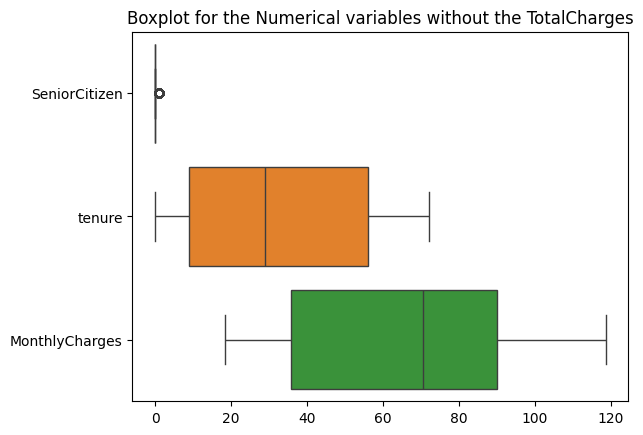

In [779]:
#plt.figure(figsize=(9,8))
data_box = df.drop('TotalCharges', axis=1)
sns.boxplot(data= data_box,orient='h' )
plt.title('Boxplot for the Numerical variables without the TotalCharges')
plt.show()

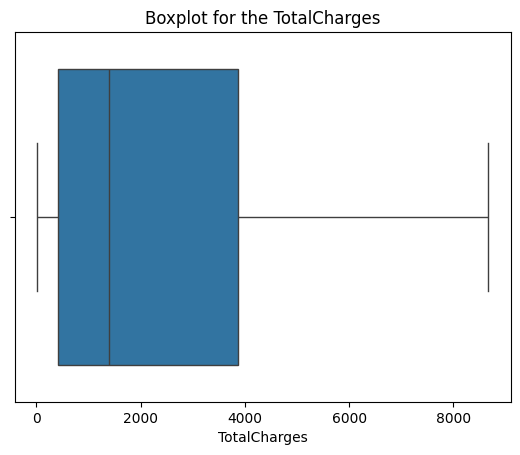

In [859]:
sns.boxplot(data= df['TotalCharges'],orient='h' )
plt.title('Boxplot for the TotalCharges')
plt.show()

Key insight
. The only column with an outlier seems to be "SeniorCitizen.

Univariate Analysis

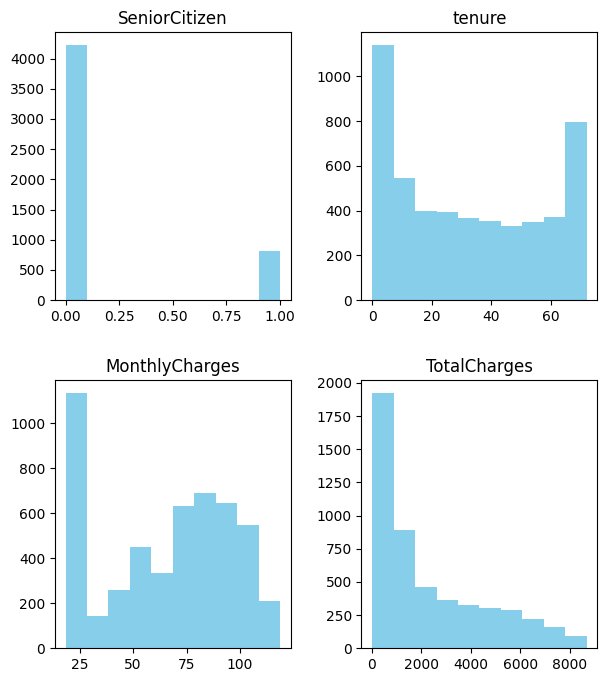

In [780]:
df.hist(figsize=(7,8), grid=False, color='skyblue')
plt.show()

Key insight

. It is observed that none of the variable's data point distributions adhere to the Gaussian distribution assumptions. Thus, there is a need to transform the variables for further analysis.

BIVARIATE ANALYSIS

In [781]:
# Find the correlation between the variables
var_corr = df.corr(numeric_only=True)
var_corr

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
SeniorCitizen,1.000000,0.004597,0.221780,0.095212
tenure,0.004597,1.000000,0.240645,0.826264
MonthlyCharges,0.221780,0.240645,1.000000,0.647007
TotalCharges,0.095212,0.826264,0.647007,1.000000


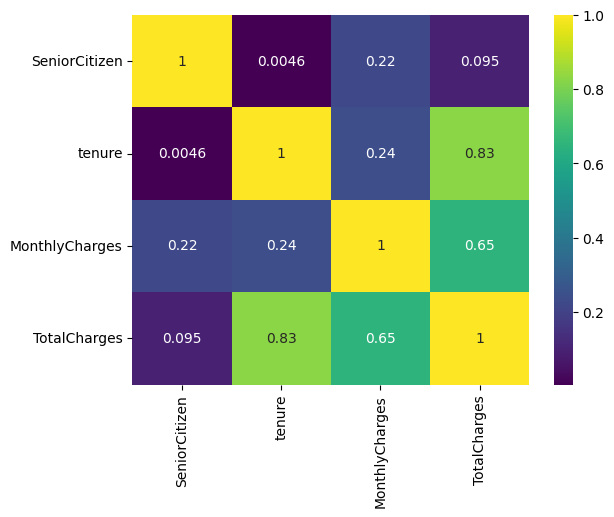

<Figure size 1000x900 with 0 Axes>

In [782]:
# Visualize the correlation with a heatmap
sns.heatmap(data=var_corr,annot=True,cmap='viridis')
plt.figure(figsize=(10,9))
plt.show()



Key insight
 The plot above reveals a moderately strong positive correlation between the variables 'tenure' and 'TotalCharges.' Additionally, there is a moderate positive correlation observed between the variables 'MonthlyCharges' and 'TotalCharges.

MULTIVARIATE ANALYSIS

<Figure size 1500x1200 with 0 Axes>

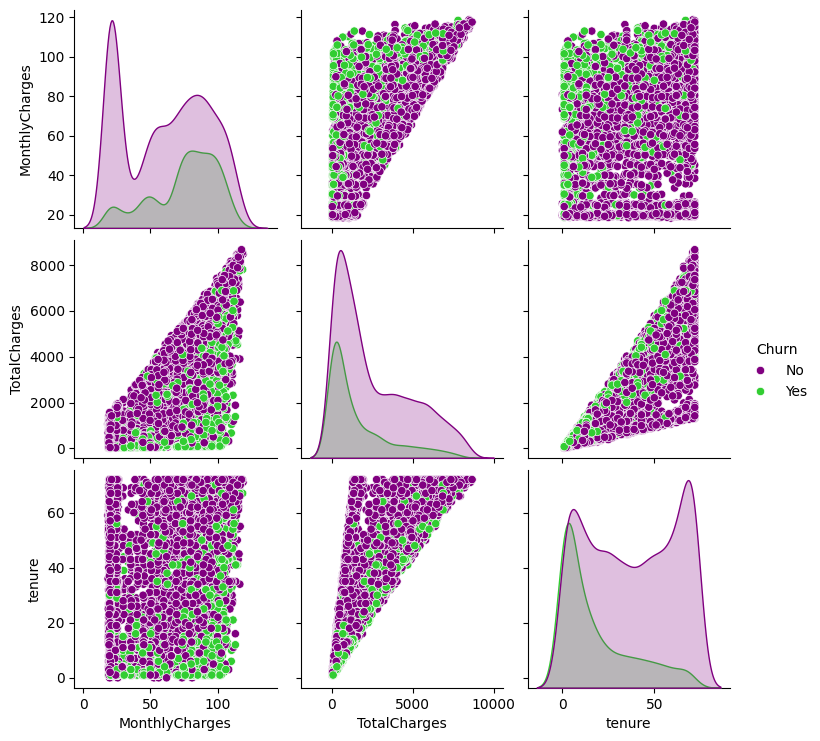

In [857]:
data = df[['Churn', 'MonthlyCharges', 'TotalCharges','tenure']]

# Define a custom palette with colors for 'Yes' and 'No'
custom_palette = {'Yes':'Limegreen','No':'Purple'}

# Use 'Churn' as the hue and provide the custom palette
plt.figure(figsize=(15,12))
sns.pairplot(data, hue='Churn', palette=custom_palette)
plt.show()

Key insight
Based on the plot above, it appears that customers with higher MonthlyCharges exhibit a tendency to both churn and remain with the company. Similarly, customers with lower TotalCharges also show a propensity to both churn and stay. Further analysis is needed to gain a clearer understanding and resolve the ambiguity in these patterns. Customers with lower tenure churn and customer higher tenure stay. 

HYPOTHESIS TESTING

HYPOTHESIS

Analyzing the impact of Monthly Charges on the Customer Churn rate

Null Hypothesis: There is no sigificant relationship between Monthly Charges and Customer Churn rate

Alternate Hypothesis: There is a significant impact of Monthly Charges on the Customer Churn rate


In [784]:
# Testing the hypothesis
group_churn = df[df['Churn'] == 'Yes']['tenure']
group_no_churn = df[df['Churn'] == 'No']['tenure']

t_statistic, p_value = ttest_ind(group_churn, group_no_churn, equal_var=False)

print(f'T-statistic: {t_statistic}')
print(f'P-value: {p_value}')

alpha = 0.05
if p_value < alpha:
    print('The difference is statistically significant. Reject the null hypothesis.')
else:
    print('The difference is not statistically significant. Fail to reject the null hypothesis.')


T-statistic: -29.189970761362208
P-value: 3.691742468508618e-164
The difference is statistically significant. Reject the null hypothesis.


ANSWERING THE ANALYTICAL QUESTIONS

1. Is there a significant difference in churn rates between different demographic groups, such as gender, senior citizens, customers with partners, and those with dependents?
2. Do customers subscribing to additional services (e.g., online security, device protection) exhibit different churn behavior compared to those who do not?
3. What is the impact of different types of contracts (month-to-month, one year, two years) on customer churn rates? Are customers with longer-term contracts more loyal?
4. Do different payment methods have an influence on customer churn rates?
5. Are long-term customers less likely to churn compared to newer ones?

1. Is there a significant difference in churn rates between different demographic groups, such as gender, senior citizens, customers with partners, and those with dependents?

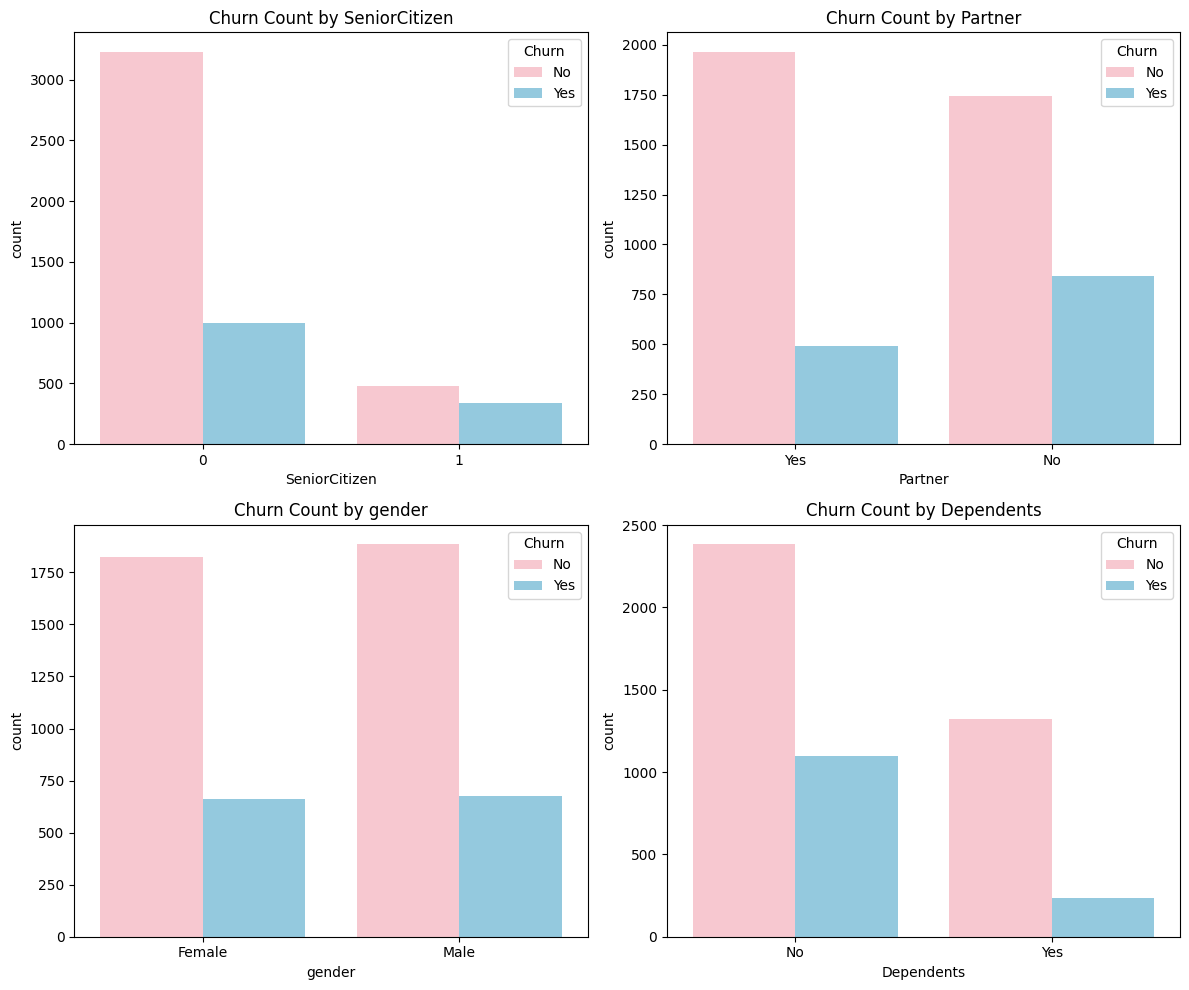

In [785]:
# List the columns and assign them to a variable
categories = ['SeniorCitizen', 'Partner', 'gender', 'Dependents']

# Set up subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

# Flatten the axes for easier indexing and iteration inside the loop
axes = axes.flatten()

# Set color palette
color_palette = {'Yes':'Skyblue','No':'Pink'}

# Loop through categories and create count plots
for i, category in enumerate(categories):
    sns.countplot(x=category, hue='Churn', data=df, hue_order=['No', 'Yes'], palette=color_palette, ax=axes[i])
    axes[i].set_title(f'Churn Count by {category}')

# Adjust layout
plt.tight_layout()
plt.show()

Key Insight
Based on the visualizations presented above, it appears that there isn't a substantial distinction in churn rates across various demographic factors. This observation stems from the consistent trend of a higher number of customers staying compared to those who churn.

2. Do customers subscribing to additional services (e.g., online security, device protection,tech support and onlinebackup) exhibit different churn behavior compared to those who do not?

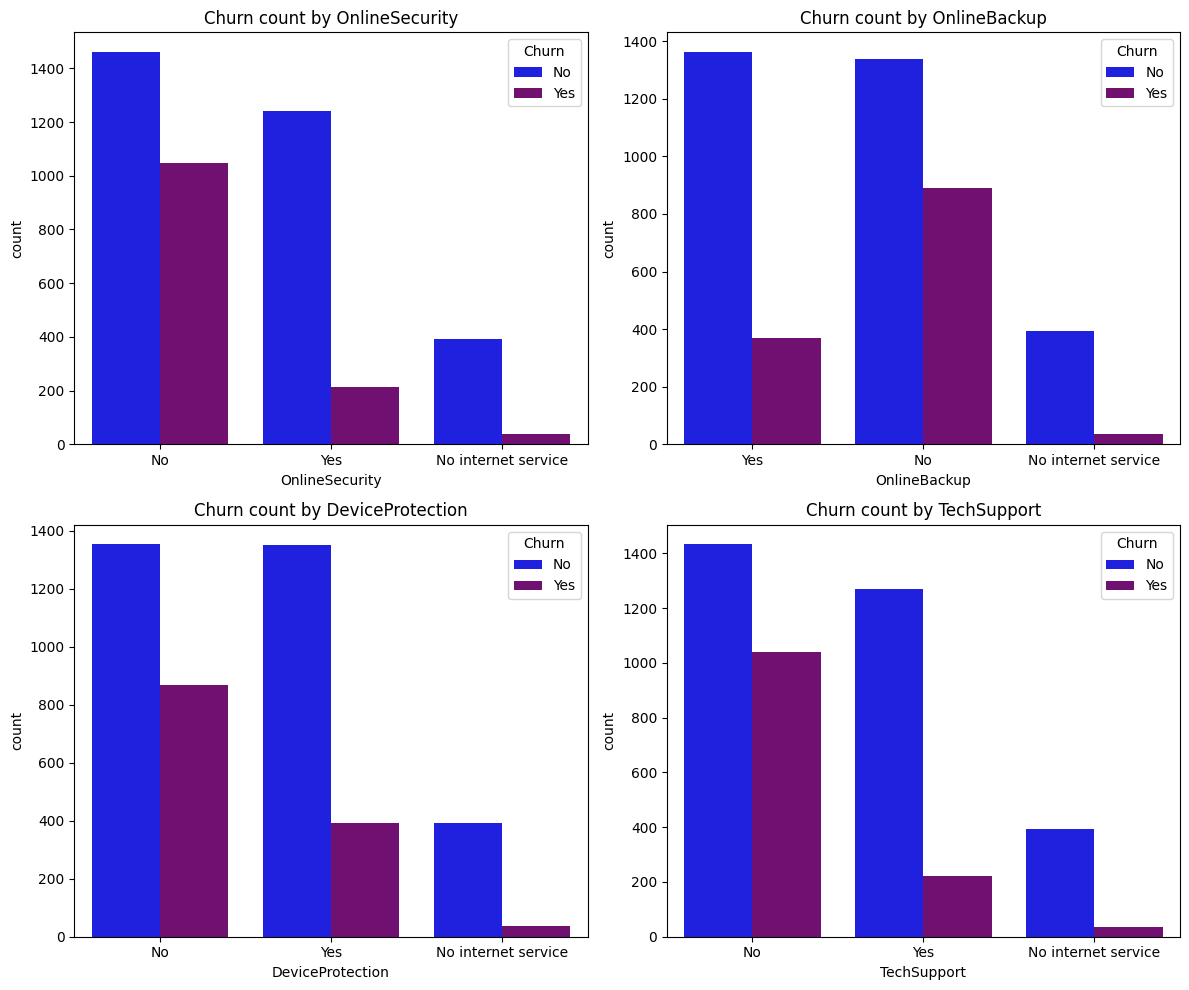

In [786]:
# Store the services in a variable called additional_service
additionalservices =['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport']
# Specify the subplot figsize and the array arrangement
fig, axes = plt.subplots(nrows=2,ncols=2,figsize=(12,10))
# Change the 2D array to 1D to iterate through the loop
axes = axes.flatten()
# set the color palette
color_pal ={'Yes':'Purple','No':'blue'}
# Loop through the additional_services and create countplot
for i, service in enumerate(additionalservices):
    sns.countplot(x=service, data=df,hue='Churn', hue_order=['No', 'Yes'], palette=color_pal,ax=axes[i])
    axes[i].set_title(f'Churn count by {service}')
# Add layout to avoid overlapping
plt.tight_layout()
plt.show()

Key insigt 
. It appears that the provision of additional services does not have a substantial impact on the churn rate. 
. The majority of customers tend to retain these services rather than opting for churn.

3. What is the impact of different types of contracts (month-to-month, one year, two years) on customer churn rates? Are customers with longer-term contracts more loyal?

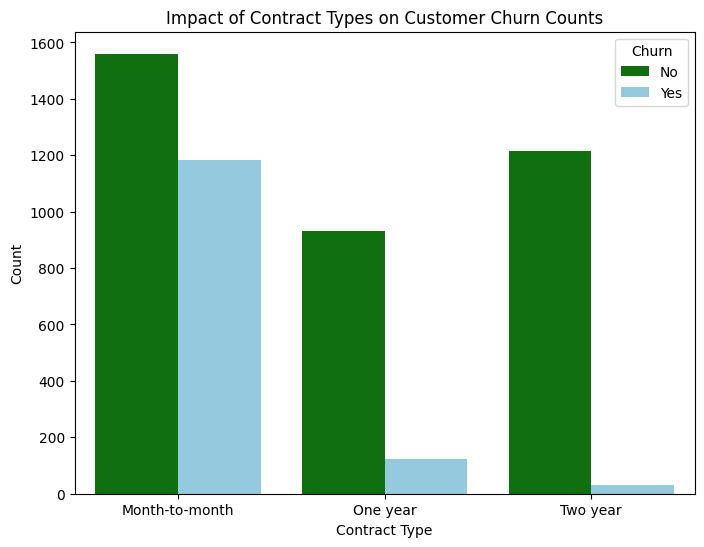

In [787]:


# Create a count plot using Seaborn
plt.figure(figsize=(8, 6))
sns.countplot(x='Contract', hue='Churn', data=df, palette={'No': 'green', 'Yes': 'skyblue'})

# Set plot labels and title
plt.xlabel('Contract Type')
plt.ylabel('Count')
plt.title('Impact of Contract Types on Customer Churn Counts')
plt.show()


Key insight
. The contract type doesn't seem to impact customer churn, as the percentage of customers staying is higher than those churning.
. The Month-to-month contract has the highest customer churn rate compare to other contract types.

4. Do different payment methods have an influence on customer churn rates?

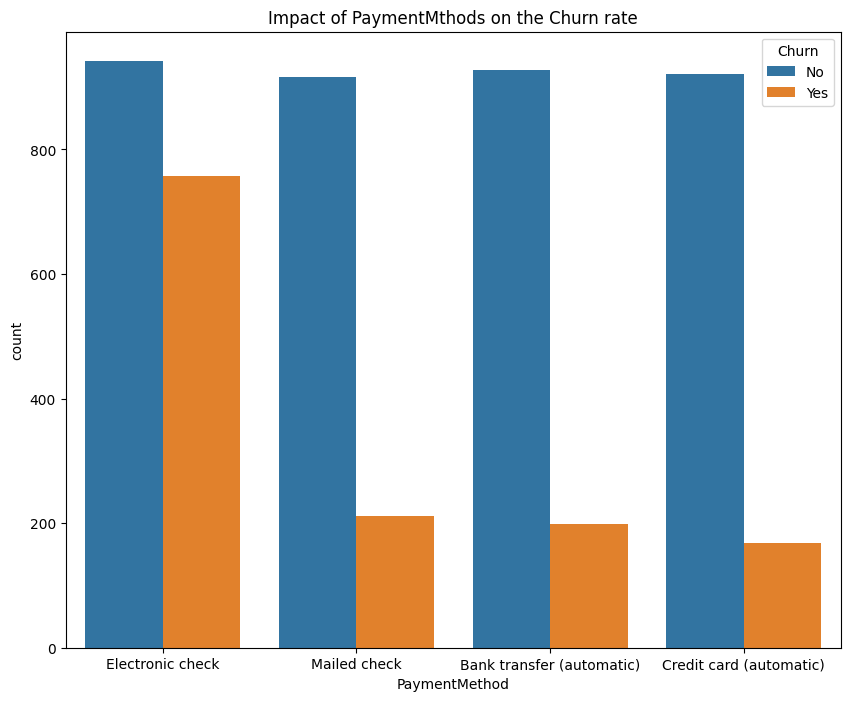

In [788]:
plt.figure(figsize=(10,8))
sns.countplot(x='PaymentMethod', hue='Churn',data=df)
plt.title('Impact of PaymentMthods on the Churn rate')
plt.show()

Key insight
. The churn rate is higher for customers using electronic checks compared to other payment methods.


Convert the dataframe to a csv file 

DATA PREPARATION

Split dataset into input(X) and target feature(y)

In [789]:
X = df.drop(['Churn','customerID'],axis=1)
X.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.850000,29.850000
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.950001,1889.500000
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.849998,108.150002
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.299999,1840.750000
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.699997,151.649994


In [790]:
y = df['Churn']
y

0        No
1        No
2       Yes
3        No
4       Yes
       ... 
5038     No
5039     No
5040     No
5041    Yes
5042     No
Name: Churn, Length: 5043, dtype: object

Split dataset into training and evaluation

In [791]:
from sklearn.model_selection import train_test_split

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42,stratify=y)

In [792]:
# Check for the X info
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5043 entries, 0 to 5042
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            5043 non-null   object 
 1   SeniorCitizen     5043 non-null   int64  
 2   Partner           5043 non-null   object 
 3   Dependents        5043 non-null   object 
 4   tenure            5043 non-null   int64  
 5   PhoneService      5043 non-null   object 
 6   MultipleLines     5043 non-null   object 
 7   InternetService   5043 non-null   object 
 8   OnlineSecurity    4392 non-null   object 
 9   OnlineBackup      4392 non-null   object 
 10  DeviceProtection  4392 non-null   object 
 11  TechSupport       4392 non-null   object 
 12  StreamingTV       4392 non-null   object 
 13  StreamingMovies   5043 non-null   object 
 14  Contract          5043 non-null   object 
 15  PaperlessBilling  5043 non-null   object 
 16  PaymentMethod     5043 non-null   object 


In [793]:
# Group X into numerical and categorical categories
X_numeric = X.select_dtypes(include='number').columns
X_numeric

Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges'], dtype='object')

In [794]:
# Display the categorical category
X_categorical = X.select_dtypes(include='object').columns
X_categorical

Index(['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod'],
      dtype='object')

PIPELINE

In [861]:

numerical_pipeline = Pipeline(steps=[
    ('num_imputer', SimpleImputer(strategy='mean')),
    ('power_transformer', PowerTransformer(method='yeo-johnson')),
    ('scaler', RobustScaler())
    
])
categorical_pipeline = Pipeline(steps=[
    ('cat_imputer', SimpleImputer(strategy='most_frequent',fill_value=None)),
    ('encoder', OneHotEncoder())
    ])
preprocessor = ColumnTransformer([
    ('numerical_pipeline', numerical_pipeline, X_numeric),
    ('categorical_pipeline', categorical_pipeline, X_categorical)
])

Label encoding

In [796]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

MACHINE LEARNING PIPELINES

DecisionTree Model

In [797]:
decision_tree_pipeline = Pipeline(steps=[
    ('preprocessor',preprocessor),
    ('decision_tree_classifier', DecisionTreeClassifier(random_state=42))
])
decision_tree_pipeline.fit(X_train, y_train_encoded)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical_pipeline',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer()),
                                                                  ('power_transformer',
                                                                   PowerTransformer()),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges'], dtype='object')),
                                                 ('categorical_pipeline',
                                                  Pipeline(steps=[('cat_imputer',
                                                                   SimpleImpu...
                                                                  ('encoder',
                                                                   OneHotEncoder())]),
                                                  Index(['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod'],
      dtype='object'))])),
                ('decision_tree_classifier',
                 DecisionTreeClassifier(random_state=42))])

Classification report for DecisionTree Model

In [798]:
from sklearn.metrics import classification_report
# Make prediction 0n the X_test 
y_predict = decision_tree_pipeline.predict(X_test)

# Print classification report
print(classification_report(y_test_encoded,y_predict))

              precision    recall  f1-score   support

           0       0.83      0.79      0.81       742
           1       0.48      0.54      0.51       267

    accuracy                           0.72      1009
   macro avg       0.65      0.66      0.66      1009
weighted avg       0.73      0.72      0.73      1009



RandomForest Model

In [799]:

random_forest_pipeline = Pipeline(steps=[
    ('preprocessor',preprocessor),
    ('random_classifier',RandomForestClassifier(random_state=42))
])
random_forest_pipeline.fit(X_train, y_train_encoded)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical_pipeline',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer()),
                                                                  ('power_transformer',
                                                                   PowerTransformer()),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges'], dtype='object')),
                                                 ('categorical_pipeline',
                                                  Pipeline(steps=[('cat_imputer',
                                                                   SimpleImpu...t')),
                                                                  ('encoder',
                                                                   OneHotEncoder())]),
                                                  Index(['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod'],
      dtype='object'))])),
                ('random_classifier', RandomForestClassifier(random_state=42))])

Classification report for RandomForest Model

In [800]:
y_pred_random = random_forest_pipeline.predict(X_test)

print(classification_report(y_test_encoded,y_pred_random))

              precision    recall  f1-score   support

           0       0.84      0.89      0.86       742
           1       0.64      0.52      0.57       267

    accuracy                           0.79      1009
   macro avg       0.74      0.71      0.72      1009
weighted avg       0.79      0.79      0.79      1009



K-Nearest Neighbors Model

In [801]:

knn_classifier_pipeline = Pipeline(steps=[
    ('preprocessor',preprocessor),
    ('knn_classifier',KNeighborsClassifier())
])
knn_classifier_pipeline.fit(X_train,y_train_encoded)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical_pipeline',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer()),
                                                                  ('power_transformer',
                                                                   PowerTransformer()),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges'], dtype='object')),
                                                 ('categorical_pipeline',
                                                  Pipeline(steps=[('cat_imputer',
                                                                   SimpleImpu...rategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder())]),
                                                  Index(['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod'],
      dtype='object'))])),
                ('knn_classifier', KNeighborsClassifier())])

Classification report for KNearestNeigbors Model

In [802]:
y_pred_knn = knn_classifier_pipeline.predict(X_test)

print(classification_report(y_test_encoded,y_pred_knn))

              precision    recall  f1-score   support

           0       0.83      0.84      0.83       742
           1       0.54      0.52      0.53       267

    accuracy                           0.75      1009
   macro avg       0.68      0.68      0.68      1009
weighted avg       0.75      0.75      0.75      1009



Logististic Regression Model

In [803]:

logistic_reg_pipeline = Pipeline(steps=[
    ('preprocessor',preprocessor),
    ('logistic_reg_model',LogisticRegression(random_state=42))
])
logistic_reg_pipeline.fit(X_train,y_train_encoded)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical_pipeline',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer()),
                                                                  ('power_transformer',
                                                                   PowerTransformer()),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges'], dtype='object')),
                                                 ('categorical_pipeline',
                                                  Pipeline(steps=[('cat_imputer',
                                                                   SimpleImpu...uent')),
                                                                  ('encoder',
                                                                   OneHotEncoder())]),
                                                  Index(['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod'],
      dtype='object'))])),
                ('logistic_reg_model', LogisticRegression(random_state=42))])

Classification Report for Logistic Regression Model

In [804]:
y_pred_logistic = logistic_reg_pipeline.predict(X_test)

print(classification_report(y_test_encoded,y_pred_logistic))

              precision    recall  f1-score   support

           0       0.85      0.89      0.87       742
           1       0.65      0.56      0.60       267

    accuracy                           0.80      1009
   macro avg       0.75      0.73      0.74      1009
weighted avg       0.80      0.80      0.80      1009



MODEL EVALUATION

COMPARE THE MODELS

In [805]:


models =[
    ('decision_tree_classifier', DecisionTreeClassifier(random_state=42)),
    ('random_classifier',RandomForestClassifier(random_state=42)),
    ('knn_classifier',KNeighborsClassifier()),
    ('logistic_reg_model',LogisticRegression(random_state=42))
]
for model_name, classifier in models:
    pipeline = Pipeline(steps=[
        ('preprocessor',preprocessor),
        ('model_name',classifier)
    ])
    pipeline.fit(X_train,y_train_encoded)
    y_pred_model = pipeline.predict(X_test)
    print(f'Report for {model_name}')
    print(classification_report(y_test_encoded,y_pred_model))
    print('='*50)

Report for decision_tree_classifier
              precision    recall  f1-score   support

           0       0.83      0.79      0.81       742
           1       0.48      0.54      0.51       267

    accuracy                           0.72      1009
   macro avg       0.65      0.66      0.66      1009
weighted avg       0.73      0.72      0.73      1009

Report for random_classifier
              precision    recall  f1-score   support

           0       0.84      0.89      0.86       742
           1       0.64      0.52      0.57       267

    accuracy                           0.79      1009
   macro avg       0.74      0.71      0.72      1009
weighted avg       0.79      0.79      0.79      1009

Report for knn_classifier
              precision    recall  f1-score   support

           0       0.83      0.84      0.83       742
           1       0.54      0.52      0.53       267

    accuracy                           0.75      1009
   macro avg       0.68      0.68    

BALANCE THE DATASET

Balance the dataset with RandomOversampler

In [806]:

sampler = RandomOverSampler()
X_train_sampler,y_train_sampler = sampler.fit_resample(X_train,y_train_encoded)

In [807]:
pd.DataFrame(y_train_sampler).value_counts() # To confirm if the target are balanced

0    2965
1    2965
Name: count, dtype: int64

Compare the Models with RandomOversampler Balanced Dataset

In [808]:
models = [
    ('decision_tree_classifier', DecisionTreeClassifier(random_state=42)),
    ('random_classifier',RandomForestClassifier(random_state=42)),
    ('knn_classifier',KNeighborsClassifier()),
    ('logistic_reg_model',LogisticRegression(random_state=42))
]
for model_name, classifier in models:
    pipeline = Pipeline(steps=[
        ('preprocessor',preprocessor),
        ('classifier',classifier)
        ])
    pipeline.fit(X_train_sampler,y_train_sampler)
    y_pred_sampler = pipeline.predict(X_test)
    print(f'Report for {model_name}')
    print(classification_report(y_pred_sampler,y_test_encoded))
    print('='*50)

Report for decision_tree_classifier
              precision    recall  f1-score   support

           0       0.80      0.84      0.82       707
           1       0.57      0.50      0.53       302

    accuracy                           0.74      1009
   macro avg       0.68      0.67      0.67      1009
weighted avg       0.73      0.74      0.73      1009



Report for random_classifier
              precision    recall  f1-score   support

           0       0.85      0.86      0.86       737
           1       0.61      0.60      0.61       272

    accuracy                           0.79      1009
   macro avg       0.73      0.73      0.73      1009
weighted avg       0.79      0.79      0.79      1009

Report for knn_classifier
              precision    recall  f1-score   support

           0       0.67      0.87      0.76       569
           1       0.73      0.44      0.55       440

    accuracy                           0.69      1009
   macro avg       0.70      0.66      0.65      1009
weighted avg       0.70      0.69      0.67      1009

Report for logistic_reg_model
              precision    recall  f1-score   support

           0       0.72      0.91      0.81       588
           1       0.81      0.51      0.62       421

    accuracy                           0.74      1009
   macro avg       0.76      0.71      0.72

BALANCE THE DATASET USING   SMOTE OVERSAMPLER

In [809]:

# Transform the X_test and fit_transform the X_train
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# Now, use the transformed data with SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_transformed, y_train_encoded)






In [810]:
# Check if the dataset is balanced
pd.DataFrame(y_train_resampled ).value_counts()

0    2965
1    2965
Name: count, dtype: int64

In [811]:
X_train_resampled = pd.DataFrame(X_train_resampled)

y_train_resampled = pd.Series(y_train_resampled)

X_test_transformed = pd.DataFrame(X_test_transformed)

To compare the models with SMOTE balanced dataset

In [812]:
models = [
    ('decision_tree_classifier', DecisionTreeClassifier(random_state=42)),
    ('random_classifier',RandomForestClassifier(random_state=42)),
    ('knn_classifier',KNeighborsClassifier()),
    ('logistic_reg_model',LogisticRegression(random_state=42))
]
for model_name, classifier in models:
    pipeline = Pipeline(steps=[
        #('preprocessor',preprocessor),
        ('classifier',classifier)
        ])
    
    pipeline.fit(X_train_resampled, y_train_resampled)
    y_pred_sampler = pipeline.predict(X_test_transformed)
    print(f'Report for {model_name}')
    print(classification_report(y_pred_sampler,y_test_encoded))
    print('='*50)

Report for decision_tree_classifier
              precision    recall  f1-score   support

           0       0.80      0.86      0.82       689
           1       0.63      0.53      0.57       320

    accuracy                           0.75      1009
   macro avg       0.71      0.69      0.70      1009
weighted avg       0.74      0.75      0.74      1009



Report for random_classifier
              precision    recall  f1-score   support

           0       0.85      0.85      0.85       734
           1       0.60      0.58      0.59       275

    accuracy                           0.78      1009
   macro avg       0.72      0.72      0.72      1009
weighted avg       0.78      0.78      0.78      1009

Report for knn_classifier
              precision    recall  f1-score   support

           0       0.66      0.87      0.75       563
           1       0.73      0.43      0.54       446

    accuracy                           0.68      1009
   macro avg       0.69      0.65      0.65      1009
weighted avg       0.69      0.68      0.66      1009

Report for logistic_reg_model
              precision    recall  f1-score   support

           0       0.74      0.91      0.82       608
           1       0.79      0.53      0.63       401

    accuracy                           0.76      1009
   macro avg       0.77      0.72      0.72

FEATURE SELECTION IMPORTANCE 

Using Random Oversampler balanced dataset to perform feature selection

In [813]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif
feature_selection = SelectKBest(mutual_info_classif, k=25)

models = [
    ('decision_tree_classifier', DecisionTreeClassifier(random_state=42)),
    ('random_classifier',RandomForestClassifier(random_state=42)),
    ('knn_classifier',KNeighborsClassifier()),
    ('logistic_reg_model',LogisticRegression(random_state=42))
]
for model_name, classifier in models:
    pipeline = Pipeline(steps=[
        ('preprocessor',preprocessor),
        ('feature',feature_selection),
        ('classifier',classifier)
        ])
    pipeline.fit(X_train_sampler,y_train_sampler)
    y_pred_sampler = pipeline.predict(X_test)
    print(f'Report for {model_name}')
    print(classification_report(y_pred_sampler,y_test_encoded))
    print('='*50)

Report for decision_tree_classifier
              precision    recall  f1-score   support

           0       0.79      0.83      0.81       711
           1       0.54      0.49      0.51       298

    accuracy                           0.73      1009
   macro avg       0.67      0.66      0.66      1009
weighted avg       0.72      0.73      0.72      1009

Report for random_classifier
              precision    recall  f1-score   support

           0       0.84      0.85      0.84       727
           1       0.60      0.57      0.58       282

    accuracy                           0.77      1009
   macro avg       0.72      0.71      0.71      1009
weighted avg       0.77      0.77      0.77      1009

Report for knn_classifier
              precision    recall  f1-score   support

           0       0.70      0.88      0.78       593
           1       0.73      0.47      0.57       416

    accuracy                           0.71      1009
   macro avg       0.72      0.67    

In [814]:
# To view the selected features

feature_indices = feature_selection.get_support(indices=True)
preprocessor_names = pipeline.named_steps['preprocessor'].get_feature_names_out()
selected_feature_names = preprocessor_names[feature_indices]
pd.DataFrame(selected_feature_names)

,0
0,numerical_pipeline__tenure
1,numerical_pipeline__MonthlyCharges
2,numerical_pipeline__TotalCharges
3,categorical_pipeline__Dependents_No
4,categorical_pipeline__Dependents_Yes
5,categorical_pipeline__InternetService_DSL
6,categorical_pipeline__InternetService_Fiber optic
7,categorical_pipeline__InternetService_No
8,categorical_pipeline__OnlineSecurity_No
9,categorical_pipeline__OnlineSecurity_None


In [815]:
# To display the features in transformed dataframe
pd.set_option('display.max_columns',None)
pd.DataFrame(preprocessor.fit_transform(X_train)).head(2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
0,0.0,0.000000,0.263607,0.292266,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,0.0,-0.224985,-0.970026,-0.539236,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


In [816]:
# Create a pipeline for logistic regression with the balanced dataset for the confusion matrix 
logistic_pipeline_balanced = Pipeline(steps=[
    ('preprocessor',preprocessor),
    ('feature_selection',feature_selection),
    ('logistic_reg_model',LogisticRegression(random_state=42))
])
logistic_pipeline_balanced.fit(X_train_sampler,y_train_sampler)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical_pipeline',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer()),
                                                                  ('power_transformer',
                                                                   PowerTransformer()),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges'], dtype='object')),
                                                 ('categorical_pipeline',
                                                  Pipeline(steps=[('cat_imputer',
                                                                   SimpleImpu...
                                                  Index(['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod'],
      dtype='object'))])),
                ('feature_selection',
                 SelectKBest(k=25,
                             score_func=<function mutual_info_classif at 0x0000027624529C60>)),
                ('logistic_reg_model', LogisticRegression(random_state=42))])

create a confusion matrix 

In [817]:
# Create a confusion matrix with the balanced logistic regression pipeline
con_y_pred = logistic_pipeline_balanced.predict(X_test)
matrix = confusion_matrix(y_test_encoded,con_y_pred)
matrix

array([[536, 206],
       [ 58, 209]], dtype=int64)

<Axes: >

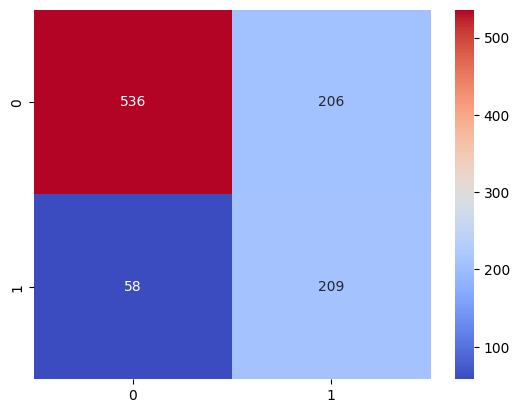

In [818]:
sns.heatmap(data=matrix, annot=True,fmt ='d', cmap='coolwarm')

ROC AND AUC

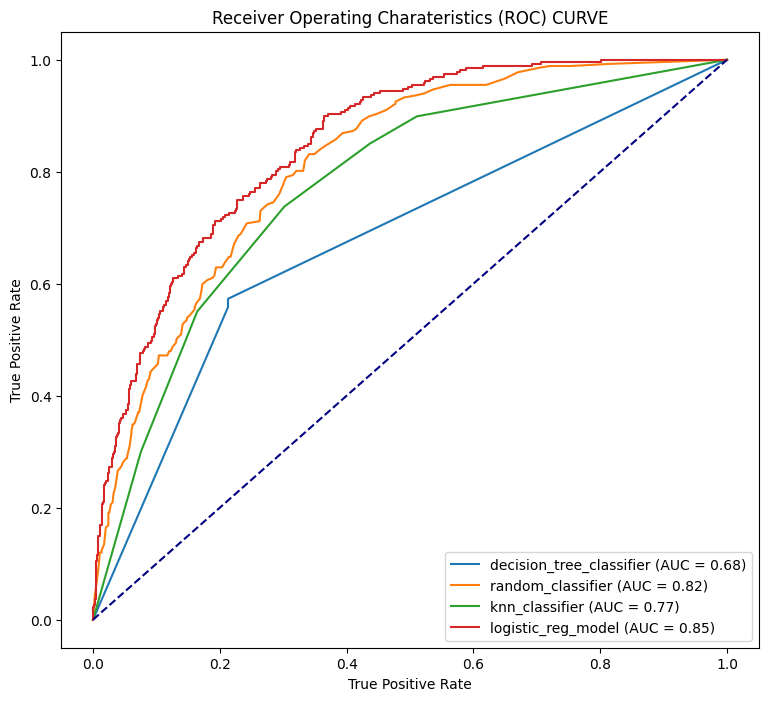

In [819]:
fig, axes = plt.subplots(figsize=(9,8))
roc_curve_data = {}
for model_name, classifier in models:
    pipeline = Pipeline(steps=[
        ('preprocessor',preprocessor),
        ('feature',feature_selection),
        ('classifier',classifier)
        ])
    pipeline.fit(X_train_sampler,y_train_sampler)
    y_pred_score = pipeline.predict_proba(X_test)[:,1]
    fpr,tpr, threshold = roc_curve(y_test_encoded,y_pred_score)
    roc_auc = auc(fpr,tpr)
    roc_curve_metrics = pd.DataFrame({'False Positive Rate':fpr,'True Positive Rate':tpr,'Threshold':threshold})
    
    roc_curve_data[model_name] = roc_curve_metrics

    axes.plot(fpr,tpr,label=f"{model_name} (AUC = {roc_auc:.2f})")
axes.plot([0,1],[0,1],color='navy',linestyle = '--')
axes.set_xlabel('True Positive Rate')
axes.set_ylabel('True Positive Rate')
axes.set_title('Receiver Operating Charateristics (ROC) CURVE')
axes.legend(loc='lower right')
plt.show()

In [820]:
roc_curve_data['logistic_reg_model']

,False Positive Rate,True Positive Rate,Threshold
0,0.000000,0.000000,inf
1,0.000000,0.003745,0.960021
2,0.000000,0.022472,0.949246
3,0.001348,0.022472,0.947084
4,0.001348,0.026217,0.945720
...,...,...,...
273,0.706199,0.992509,0.087719
274,0.706199,0.996255,0.087590
275,0.801887,0.996255,0.044772
276,0.801887,1.000000,0.044538


In [821]:
# Set threshold to be 0.36 to improve the performance of the model
threshold = 0.36
y_pred_prob_thre = logistic_pipeline_balanced.predict_proba(X_test)[:,1]
binary_prediction = (y_pred_prob_thre >= threshold )
thres_matrix = confusion_matrix(y_test_encoded,binary_prediction)
thres_matrix


array([[529, 213],
       [ 62, 205]], dtype=int64)

<Axes: >

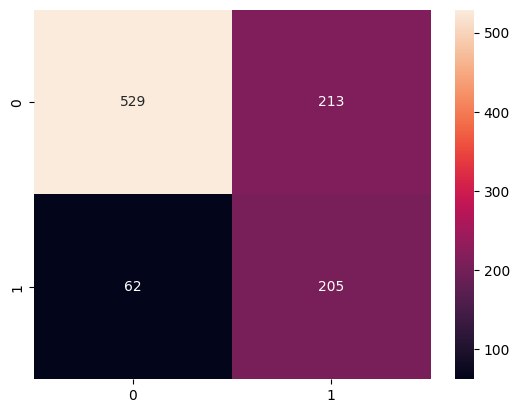

In [822]:
# Display the confusion matrix in a heatmap
sns.heatmap(data=thres_matrix,annot=True,fmt='d')

HYPERPARAMETER TUNING

Using Randomforest Model

In [823]:
# Create an instance of the model and get the parameters
rd_classifier = RandomForestClassifier()
rd_classifier.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [824]:
# Define a smaller parameter grid for fast execution
parameters = {
    'random_classifier__n_estimators': [50, 100],
    'random_classifier__max_depth': [None, 10],
    'random_classifier__min_samples_split': [2, 5],
    'random_classifier__min_samples_leaf': [1, 2]
}

# Create the GridSearchCV object
rd_searcher = GridSearchCV(estimator=random_forest_pipeline, param_grid=parameters,
                        scoring=['f1','accuracy','precision', 'recall', 'roc_auc'],
                        refit='f1',
                        cv=3,
                        verbose=3)  

# Fit the GridSearchCV on the training data
rd_searcher.fit(X_train, y_train_encoded)




Fitting 3 folds for each of 16 candidates, totalling 48 fits


[CV 1/3] END random_classifier__max_depth=None, random_classifier__min_samples_leaf=1, random_classifier__min_samples_split=2, random_classifier__n_estimators=50; accuracy: (test=0.780) f1: (test=0.533) precision: (test=0.610) recall: (test=0.473) roc_auc: (test=0.811) total time=   1.1s
[CV 2/3] END random_classifier__max_depth=None, random_classifier__min_samples_leaf=1, random_classifier__min_samples_split=2, random_classifier__n_estimators=50; accuracy: (test=0.797) f1: (test=0.563) precision: (test=0.654) recall: (test=0.494) roc_auc: (test=0.832) total time=   0.8s
[CV 3/3] END random_classifier__max_depth=None, random_classifier__min_samples_leaf=1, random_classifier__min_samples_split=2, random_classifier__n_estimators=50; accuracy: (test=0.781) f1: (test=0.535) precision: (test=0.612) recall: (test=0.475) roc_auc: (test=0.835) total time=   0.9s
[CV 1/3] END random_classifier__max_depth=None, random_classifier__min_samples_leaf=1, random_classifier__min_samples_split=2, random

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('numerical_pipeline',
                                                                         Pipeline(steps=[('num_imputer',
                                                                                          SimpleImputer()),
                                                                                         ('power_transformer',
                                                                                          PowerTransformer()),
                                                                                         ('scaler',
                                                                                          RobustScaler())]),
                                                                         Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges'], dtype='object')),
                                                                        ('categorical_pipeline',
                                                                         Pipeline(step...
       'PaperlessBilling', 'PaymentMethod'],
      dtype='object'))])),
                                       ('random_classifier',
                                        RandomForestClassifier(random_state=42))]),
             param_grid={'random_classifier__max_depth': [None, 10],
                         'random_classifier__min_samples_leaf': [1, 2],
                         'random_classifier__min_samples_split': [2, 5],
                         'random_classifier__n_estimators': [50, 100]},
             refit='f1',
             scoring=['f1', 'accuracy', 'precision', 'recall', 'roc_auc'],
             verbose=3)

In [825]:
search_history = pd.DataFrame(rd_searcher.cv_results_)
search_history

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_random_classifier__max_depth,param_random_classifier__min_samples_leaf,param_random_classifier__min_samples_split,param_random_classifier__n_estimators,params,split0_test_f1,split1_test_f1,split2_test_f1,mean_test_f1,std_test_f1,rank_test_f1,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,split0_test_precision,split1_test_precision,split2_test_precision,mean_test_precision,std_test_precision,rank_test_precision,split0_test_recall,split1_test_recall,split2_test_recall,mean_test_recall,std_test_recall,rank_test_recall,split0_test_roc_auc,split1_test_roc_auc,split2_test_roc_auc,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc
0,0.911508,0.124301,0.141472,0.013596,None,1,2,50,"{'random_classifier__max_depth': None, 'random...",0.533123,0.563200,0.534810,0.543711,0.013798,16,0.779926,0.797026,0.781250,0.786067,0.007768,16,0.610108,0.654275,0.612319,0.625567,0.020319,15,0.473389,0.494382,0.474719,0.480830,0.009598,16,0.811292,0.832392,0.834949,0.826211,0.010601,16
1,1.578216,0.037423,0.198734,0.020737,None,1,2,100,"{'random_classifier__max_depth': None, 'random...",0.533123,0.563291,0.549689,0.548701,0.012336,15,0.779926,0.794796,0.784226,0.786316,0.006248,15,0.610108,0.644928,0.614583,0.623206,0.015467,16,0.473389,0.500000,0.497191,0.490193,0.011938,15,0.813639,0.838277,0.836325,0.829414,0.011183,15
2,0.749852,0.043115,0.134244,0.016098,None,1,5,50,"{'random_classifier__max_depth': None, 'random...",0.555205,0.569157,0.586957,0.570440,0.012994,13,0.790335,0.798513,0.802083,0.796977,0.004918,14,0.635379,0.655678,0.656250,0.649102,0.009707,14,0.492997,0.502809,0.530899,0.508902,0.016062,12,0.827913,0.842401,0.841315,0.837210,0.006589,14
3,1.578061,0.108829,0.235602,0.010425,None,1,5,100,"{'random_classifier__max_depth': None, 'random...",0.570064,0.572327,0.587869,0.576753,0.007914,10,0.799257,0.797770,0.802827,0.799951,0.002122,9,0.660517,0.650000,0.658537,0.656351,0.004563,8,0.501401,0.511236,0.530899,0.514512,0.012263,8,0.830911,0.845364,0.843864,0.840046,0.006489,13
4,0.856302,0.023228,0.160612,0.024308,None,2,2,50,"{'random_classifier__max_depth': None, 'random...",0.540453,0.568690,0.594181,0.567775,0.021944,14,0.788848,0.799257,0.802827,0.796977,0.005930,13,0.639847,0.659259,0.653199,0.650768,0.008109,13,0.467787,0.500000,0.544944,0.504244,0.031642,14,0.828185,0.850625,0.846106,0.841638,0.009691,12
5,1.764949,0.090987,0.345426,0.129814,None,2,2,100,"{'random_classifier__max_depth': None, 'random...",0.545455,0.576000,0.608828,0.576761,0.025878,9,0.791822,0.802974,0.808780,0.801192,0.007037,4,0.648649,0.669145,0.664452,0.660748,0.008768,4,0.470588,0.505618,0.561798,0.512668,0.037568,10,0.829377,0.852041,0.847710,0.843043,0.009824,10
6,0.758032,0.053547,0.131542,0.004560,None,2,5,50,"{'random_classifier__max_depth': None, 'random...",0.546341,0.581994,0.594427,0.574254,0.020379,12,0.792565,0.806691,0.805060,0.801439,0.006310,3,0.651163,0.680451,0.662069,0.664561,0.012086,2,0.470588,0.508427,0.539326,0.506114,0.028110,13,0.831547,0.850229,0.847283,0.843020,0.008201,11
7,1.404890,0.089582,0.227863,0.070103,None,2,5,100,"{'random_classifier__max_depth': None, 'random...",0.562701,0.580952,0.602782,0.582145,0.016385,2,0.797770,0.803717,0.808780,0.803422,0.004500,1,0.660377,0.667883,0.670103,0.666121,0.004161,1,0.490196,0.514045,0.547753,0.517331,0.023612,5,0.833370,0.853386,0.849081,0.845279,0.008602,6
8,0.672635,0.034057,0.123048,0.011034,10,1,2,50,"{'random_classifier__max_depth': 10, 'random_c...",0.564669,0.576433,0.597561,0.579554,0.013608,4,0.794796,0.802230,0.803571,0.800199,0.003860,8,0.646209,0.665441,0.653333,0.654995,0.007939,10,0.501401,0.508427,0.550562,0.520130,0.021709,2,0.832670,0.848009,0.848502,0.843060,0.007350,9
9,1.187963,0.047319,0.264793,0.003200,10,1,2,100,"{'random_classifier__max_depth': 10, 'random_c...",0.575949,0.583732,0.592705,0.584129,0.006846,1,0.800743,0.805948,

In [826]:
rd_best_params = rd_searcher.best_params_
rd_best_params

{'random_classifier__max_depth': 10,
 'random_classifier__min_samples_leaf': 1,
 'random_classifier__min_samples_split': 2,
 'random_classifier__n_estimators': 100}

In [827]:
rd_tuned = rd_searcher.best_estimator_
rd_tuned

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical_pipeline',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer()),
                                                                  ('power_transformer',
                                                                   PowerTransformer()),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges'], dtype='object')),
                                                 ('categorical_pipeline',
                                                  Pipeline(steps=[('cat_imputer',
                                                                   SimpleImpu...
                                                                  ('encoder',
                                                                   OneHotEncoder())]),
                                                  Index(['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod'],
      dtype='object'))])),
                ('random_classifier',
                 RandomForestClassifier(max_depth=10, random_state=42))])

HYPERPARAMETER TUNING

Using KNeighbors Model

In [828]:
# Create an instance of the model
knn = KNeighborsClassifier()
knn.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

In [829]:
# Specify the parameter grid for hyperparameter tuning
param_grid = {
    'knn_classifier__n_neighbors': [3, 5, 7],
    'knn_classifier__weights': ['uniform', 'distance'],
    'knn_classifier__p': [1, 2],
    'knn_classifier__metric': ['euclidean', 'manhattan', 'minkowski']
}

# Create the searcher instance
knn_searcher = GridSearchCV(estimator=knn_classifier_pipeline, param_grid=param_grid,
                             scoring=['f1','accuracy', 'precision', 'recall'],
                             refit='f1',cv=3, verbose=2)

# Fit the searcher on the training data
knn_searcher.fit(X_train, y_train_encoded)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] END knn_classifier__metric=euclidean, knn_classifier__n_neighbors=3, knn_classifier__p=1, knn_classifier__weights=uniform; total time=   0.4s


[CV] END knn_classifier__metric=euclidean, knn_classifier__n_neighbors=3, knn_classifier__p=1, knn_classifier__weights=uniform; total time=   0.5s
[CV] END knn_classifier__metric=euclidean, knn_classifier__n_neighbors=3, knn_classifier__p=1, knn_classifier__weights=uniform; total time=   0.3s
[CV] END knn_classifier__metric=euclidean, knn_classifier__n_neighbors=3, knn_classifier__p=1, knn_classifier__weights=distance; total time=   0.1s
[CV] END knn_classifier__metric=euclidean, knn_classifier__n_neighbors=3, knn_classifier__p=1, knn_classifier__weights=distance; total time=   0.2s
[CV] END knn_classifier__metric=euclidean, knn_classifier__n_neighbors=3, knn_classifier__p=1, knn_classifier__weights=distance; total time=   0.1s
[CV] END knn_classifier__metric=euclidean, knn_classifier__n_neighbors=3, knn_classifier__p=2, knn_classifier__weights=uniform; total time=   0.3s
[CV] END knn_classifier__metric=euclidean, knn_classifier__n_neighbors=3, knn_classifier__p=2, knn_classifier__weig

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('numerical_pipeline',
                                                                         Pipeline(steps=[('num_imputer',
                                                                                          SimpleImputer()),
                                                                                         ('power_transformer',
                                                                                          PowerTransformer()),
                                                                                         ('scaler',
                                                                                          RobustScaler())]),
                                                                         Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges'], dtype='object')),
                                                                        ('categorical_pipeline',
                                                                         Pipeline(step...
       'PaperlessBilling', 'PaymentMethod'],
      dtype='object'))])),
                                       ('knn_classifier',
                                        KNeighborsClassifier())]),
             param_grid={'knn_classifier__metric': ['euclidean', 'manhattan',
                                                    'minkowski'],
                         'knn_classifier__n_neighbors': [3, 5, 7],
                         'knn_classifier__p': [1, 2],
                         'knn_classifier__weights': ['uniform', 'distance']},
             refit='f1', scoring=['f1', 'accuracy', 'precision', 'recall'],
             verbose=2)

In [830]:
search_history = pd.DataFrame(knn_searcher.cv_results_)
search_history

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_knn_classifier__metric,param_knn_classifier__n_neighbors,param_knn_classifier__p,param_knn_classifier__weights,params,split0_test_f1,split1_test_f1,split2_test_f1,mean_test_f1,std_test_f1,rank_test_f1,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,split0_test_precision,split1_test_precision,split2_test_precision,mean_test_precision,std_test_precision,rank_test_precision,split0_test_recall,split1_test_recall,split2_test_recall,mean_test_recall,std_test_recall,rank_test_recall
0,0.158742,0.029607,0.335083,0.053552,euclidean,3,1,uniform,"{'knn_classifier__metric': 'euclidean', 'knn_c...",0.522472,0.546495,0.539419,0.536129,0.010080,22,0.747212,0.764312,0.752232,0.754585,0.007177,28,0.523944,0.556851,0.531335,0.537377,0.014097,28,0.521008,0.536517,0.547753,0.535093,0.010965,19
1,0.119994,0.012680,0.096326,0.021060,euclidean,3,1,distance,"{'knn_classifier__metric': 'euclidean', 'knn_c...",0.507757,0.533524,0.507003,0.516095,0.012328,34,0.740520,0.756877,0.738095,0.745164,0.008341,34,0.511364,0.542029,0.505587,0.519660,0.015992,34,0.504202,0.525281,0.508427,0.512637,0.009106,31
2,0.134703,0.012965,0.269319,0.013855,euclidean,3,2,uniform,"{'knn_classifier__metric': 'euclidean', 'knn_c...",0.522472,0.546495,0.539419,0.536129,0.010080,22,0.747212,0.764312,0.752232,0.754585,0.007177,28,0.523944,0.556851,0.531335,0.537377,0.014097,28,0.521008,0.536517,0.547753,0.535093,0.010965,19
3,0.118843,0.008509,0.086711,0.002520,euclidean,3,2,distance,"{'knn_classifier__metric': 'euclidean', 'knn_c...",0.507757,0.533524,0.507003,0.516095,0.012328,34,0.740520,0.756877,0.738095,0.745164,0.008341,34,0.511364,0.542029,0.505587,0.519660,0.015992,34,0.504202,0.525281,0.508427,0.512637,0.009106,31
4,0.133627,0.022321,0.256932,0.026930,euclidean,5,1,uniform,"{'knn_classifier__metric': 'euclidean', 'knn_c...",0.531250,0.573888,0.565401,0.556846,0.018428,7,0.754647,0.779182,0.770089,0.767973,0.010128,10,0.538905,0.586510,0.566197,0.563871,0.019504,10,0.523810,0.561798,0.564607,0.550071,0.018605,7
5,0.119135,0.006815,0.084216,0.000891,euclidean,5,1,distance,"{'knn_classifier__metric': 'euclidean', 'knn_c...",0.518414,0.554913,0.547250,0.540192,0.015714,19,0.747212,0.771004,0.761161,0.759792,0.009761,19,0.524355,0.571429,0.549575,0.548453,0.019234,19,0.512605,0.539326,0.544944,0.532292,0.014108,22
6,0.135866,0.025982,0.237594,0.012474,euclidean,5,2,uniform,"{'knn_classifier__metric': 'euclidean', 'knn_c...",0.531250,0.573888,0.565401,0.556846,0.018428,7,0.754647,0.779182,0.770089,0.767973,0.010128,10,0.538905,0.586510,0.566197,0.563871,0.019504,10,0.523810,0.561798,0.564607,0.550071,0.018605,7
7,0.138506,0.026784,0.096594,0.004713,euclidean,5,2,distance,"{'knn_classifier__metric': 'euclidean', 'knn_c...",0.518414,0.554913,0.547250,0.540192,0.015714,19,0.747212,0.771004,0.761161,0.759792,0.009761,19,0.524355,0.571429,0.549575,0.548453,0.019234,19,0.512605,0.539326,0.544944,0.532292,0.014108,22
8,0.137680,0.014360,0.291393,0.022822,euclidean,7,1,uniform,"{'knn_classifier__metric': 'euclidean', 'knn_c...",0.554765,0.591304,0.563025,0.569698,0.015646,4,0.767286,0.790335,0.767857,0.775159,0.010733,4,0.563584,0.610778,0.561453,0.578605,0.022767,4,0.546218,0.573034,0.564607,0.561286,0.011196,1
9,0.121083,0.002850,0.083510,0.001164,euclidean,7,1,distance,"{'knn_classifier__metric': 'euclidean', 'knn_c...",0.538244,0.562319,0.541374,0.547312,0.010688,13,0.757621,0.775465,0.756696,0.763261,0.008638,16,0.544413,0.580838,0.540616,0.555289,0.018132,16,0.532213,0.544944,0.542135,0.539764,0.005461,13


In [831]:
knn_searcher.best_params_

{'knn_classifier__metric': 'manhattan',
 'knn_classifier__n_neighbors': 7,
 'knn_classifier__p': 1,
 'knn_classifier__weights': 'uniform'}

In [832]:
knn_tuned = knn_searcher.best_estimator_
knn_tuned

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical_pipeline',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer()),
                                                                  ('power_transformer',
                                                                   PowerTransformer()),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges'], dtype='object')),
                                                 ('categorical_pipeline',
                                                  Pipeline(steps=[('cat_imputer',
                                                                   SimpleImpu...
                                                                   OneHotEncoder())]),
                                                  Index(['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod'],
      dtype='object'))])),
                ('knn_classifier',
                 KNeighborsClassifier(metric='manhattan', n_neighbors=7, p=1))])

Tuning with Decision Tree Model

In [833]:
# Create an instance for the decision tree model and get the parameters
dt_classifier = DecisionTreeClassifier()
dt_classifier.get_params()


{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In [834]:
# Set the parameters within the DecisionTreeClassifier
dt_parameters = {
    'decision_tree_classifier__criterion': ['gini', 'entropy'],
    'decision_tree_classifier__splitter': ['best', 'random'],
    'decision_tree_classifier__max_depth': [None, 5, 10],
    'decision_tree_classifier__min_samples_split': [2, 5, 10],
    'decision_tree_classifier__min_samples_leaf': [1, 2, 4],
}

# Create the searcher instance
dt_searcher = GridSearchCV(
    estimator=decision_tree_pipeline,
    param_grid=dt_parameters,
    scoring=['f1','accuracy','precision','recall'],
      refit='f1',  
    cv=3,
    verbose=2
)

# Fit the decision tree searcher with the trained dataset
dt_searcher.fit(X_train, y_train_encoded)

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END decision_tree_classifier__criterion=gini, decision_tree_classifier__max_depth=None, decision_tree_classifier__min_samples_leaf=1, decision_tree_classifier__min_samples_split=2, decision_tree_classifier__splitter=best; total time=   0.3s
[CV] END decision_tree_classifier__criterion=gini, decision_tree_classifier__max_depth=None, decision_tree_classifier__min_samples_leaf=1, decision_tree_classifier__min_samples_split=2, decision_tree_classifier__splitter=best; total time=   0.3s


[CV] END decision_tree_classifier__criterion=gini, decision_tree_classifier__max_depth=None, decision_tree_classifier__min_samples_leaf=1, decision_tree_classifier__min_samples_split=2, decision_tree_classifier__splitter=best; total time=   0.3s
[CV] END decision_tree_classifier__criterion=gini, decision_tree_classifier__max_depth=None, decision_tree_classifier__min_samples_leaf=1, decision_tree_classifier__min_samples_split=2, decision_tree_classifier__splitter=random; total time=   0.2s
[CV] END decision_tree_classifier__criterion=gini, decision_tree_classifier__max_depth=None, decision_tree_classifier__min_samples_leaf=1, decision_tree_classifier__min_samples_split=2, decision_tree_classifier__splitter=random; total time=   0.1s
[CV] END decision_tree_classifier__criterion=gini, decision_tree_classifier__max_depth=None, decision_tree_classifier__min_samples_leaf=1, decision_tree_classifier__min_samples_split=2, decision_tree_classifier__splitter=random; total time=   0.1s
[CV] END d

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('numerical_pipeline',
                                                                         Pipeline(steps=[('num_imputer',
                                                                                          SimpleImputer()),
                                                                                         ('power_transformer',
                                                                                          PowerTransformer()),
                                                                                         ('scaler',
                                                                                          RobustScaler())]),
                                                                         Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges'], dtype='object')),
                                                                        ('categorical_pipeline',
                                                                         Pipeline(step...
             param_grid={'decision_tree_classifier__criterion': ['gini',
                                                                 'entropy'],
                         'decision_tree_classifier__max_depth': [None, 5, 10],
                         'decision_tree_classifier__min_samples_leaf': [1, 2,
                                                                        4],
                         'decision_tree_classifier__min_samples_split': [2, 5,
                                                                         10],
                         'decision_tree_classifier__splitter': ['best',
                                                                'random']},
             refit='f1', scoring=['f1', 'accuracy', 'precision', 'recall'],
             verbose=2)

In [835]:
search_history = pd.DataFrame(dt_searcher.cv_results_)
search_history

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_decision_tree_classifier__criterion,param_decision_tree_classifier__max_depth,param_decision_tree_classifier__min_samples_leaf,param_decision_tree_classifier__min_samples_split,param_decision_tree_classifier__splitter,params,split0_test_f1,split1_test_f1,split2_test_f1,mean_test_f1,std_test_f1,rank_test_f1,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,split0_test_precision,split1_test_precision,split2_test_precision,mean_test_precision,std_test_precision,rank_test_precision,split0_test_recall,split1_test_recall,split2_test_recall,mean_test_recall,std_test_recall,rank_test_recall
0,0.279680,0.011709,0.090499,0.008884,gini,None,1,2,best,{'decision_tree_classifier__criterion': 'gini'...,0.507586,0.530245,0.497866,0.511899,0.013566,87,0.734572,0.728625,0.737351,0.733516,0.003640,104,0.500000,0.489311,0.504323,0.497878,0.006309,104,0.515406,0.578652,0.491573,0.528544,0.036743,23
1,0.174182,0.024289,0.052722,0.010059,gini,None,1,2,random,{'decision_tree_classifier__criterion': 'gini'...,0.509749,0.497253,0.535714,0.514239,0.016020,85,0.738290,0.727881,0.748512,0.738228,0.008423,101,0.506925,0.486559,0.524194,0.505893,0.015382,102,0.512605,0.508427,0.547753,0.522928,0.017636,28
2,0.209877,0.017208,0.048331,0.004932,gini,None,1,5,best,{'decision_tree_classifier__criterion': 'gini'...,0.484761,0.529891,0.490399,0.501684,0.020078,98,0.736059,0.742751,0.743304,0.740705,0.003292,99,0.503012,0.513158,0.517134,0.511101,0.005946,99,0.467787,0.547753,0.466292,0.493944,0.038053,61
3,0.175983,0.029649,0.055351,0.008480,gini,None,1,5,random,{'decision_tree_classifier__criterion': 'gini'...,0.509461,0.496218,0.527859,0.511180,0.012975,89,0.749442,0.752416,0.760417,0.754092,0.004634,76,0.530303,0.537705,0.552147,0.540052,0.009071,74,0.490196,0.460674,0.505618,0.485496,0.018647,83
4,0.177120,0.007424,0.044302,0.003236,gini,None,1,10,best,{'decision_tree_classifier__criterion': 'gini'...,0.492754,0.532236,0.500000,0.508330,0.017161,93,0.739777,0.746468,0.744048,0.743431,0.002766,97,0.510511,0.520107,0.518072,0.516230,0.004129,98,0.476190,0.544944,0.483146,0.501427,0.030902,51
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,0.135835,0.005250,0.043011,0.000720,entropy,10,4,2,random,{'decision_tree_classifier__criterion': 'entro...,0.520179,0.555391,0.540230,0.538600,0.014421,51,0.761338,0.776208,0.761905,0.766484,0.006880,50,0.557692,0.585670,0.552941,0.565434,0.014439,50,0.487395,0.528090,0.528090,0.514525,0.019184,35
104,0.175244,0.024353,0.040768,0.002358,entropy,10,4,5,best,{'decision_tree_classifier__criterion': 'entro...,0.539230,0.538354,0.541311,0.539631,0.001240,49,0.759851,0.753903,0.760417,0.758057,0.002946,65,0.549419,0.534626,0.549133,0.544393,0.006907,68,0.529412,0.542135,0.533708,0.535085,0.005285,12
105,0.145672,0.024488,0.045552,0.001228,entropy,10,4,5,random,{'decision_tree_classifier__criterion': 'entro...,0.520179,0.555391,0.540230,0.538600,0.014421,51,0.761338,0.776208,0.761905,0.766484,0.006880,50,0.557692,0.585670,0.552941,0.565434,0.014439,50,0.487395,0.528090,0.528090,0.514525,0.019184,35
106,0.153880,0.001984,0.041424,0.003319,entropy,10,4,10,best,{'decision_tree_classifier__criterion': 'entro...,0.554930,0.550562,0.554184,0.553225,0.001908,29,0.765056,0.762082,0.758185,0.761774,0.002814,56,0.558074,0.550562,0.541555,0.550063,0.006753,62,0.551821,0.550562,0.567416,0.556599,0.007666,2


In [836]:
# Display the best parameters for decision tree
dt_searcher.best_params_

{'decision_tree_classifier__criterion': 'entropy',
 'decision_tree_classifier__max_depth': 5,
 'decision_tree_classifier__min_samples_leaf': 1,
 'decision_tree_classifier__min_samples_split': 2,
 'decision_tree_classifier__splitter': 'random'}

In [837]:
# Show the best estimator for decision tree model
dt_tuned = dt_searcher.best_estimator_
dt_tuned

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical_pipeline',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer()),
                                                                  ('power_transformer',
                                                                   PowerTransformer()),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges'], dtype='object')),
                                                 ('categorical_pipeline',
                                                  Pipeline(steps=[('cat_imputer',
                                                                   SimpleImpu...
                                                  Index(['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod'],
      dtype='object'))])),
                ('decision_tree_classifier',
                 DecisionTreeClassifier(criterion='entropy', max_depth=5,
                                        random_state=42, splitter='random'))])

Tuning with Logistic Regression Model

In [838]:
# Get the model hyperparameters
logist_model = LogisticRegression()
logist_model.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [839]:
# Set the parameters for the logistics regression
params = {
    'logistic_reg_model__penalty': ['l1', 'l2'],
    'logistic_reg_model__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'logistic_reg_model__solver': ['liblinear', 'lbfgs'],
    'logistic_reg_model__max_iter': [100, 200, 300]
}
# Create an instance for the searcher
logistic_searcher = GridSearchCV(
    estimator=logistic_reg_pipeline,
    param_grid=params,
    scoring=['f1', 'accuracy', 'precision', 'recall'],
    refit='f1',
    cv=3,
    verbose=2
)

# Fit the searcher with the training dataset
logistic_searcher.fit(X_train, y_train_encoded)


Fitting 3 folds for each of 72 candidates, totalling 216 fits
[CV] END logistic_reg_model__C=0.001, logistic_reg_model__max_iter=100, logistic_reg_model__penalty=l1, logistic_reg_model__solver=liblinear; total time=   0.1s
[CV] END logistic_reg_model__C=0.001, logistic_reg_model__max_iter=100, logistic_reg_model__penalty=l1, logistic_reg_model__solver=liblinear; total time=   0.2s
[CV] END logistic_reg_model__C=0.001, logistic_reg_model__max_iter=100, logistic_reg_model__penalty=l1, logistic_reg_model__solver=liblinear; total time=   0.1s


[CV] END logistic_reg_model__C=0.001, logistic_reg_model__max_iter=100, logistic_reg_model__penalty=l1, logistic_reg_model__solver=lbfgs; total time=   0.1s
[CV] END logistic_reg_model__C=0.001, logistic_reg_model__max_iter=100, logistic_reg_model__penalty=l1, logistic_reg_model__solver=lbfgs; total time=   0.1s
[CV] END logistic_reg_model__C=0.001, logistic_reg_model__max_iter=100, logistic_reg_model__penalty=l1, logistic_reg_model__solver=lbfgs; total time=   0.1s
[CV] END logistic_reg_model__C=0.001, logistic_reg_model__max_iter=100, logistic_reg_model__penalty=l2, logistic_reg_model__solver=liblinear; total time=   0.1s
[CV] END logistic_reg_model__C=0.001, logistic_reg_model__max_iter=100, logistic_reg_model__penalty=l2, logistic_reg_model__solver=liblinear; total time=   0.1s
[CV] END logistic_reg_model__C=0.001, logistic_reg_model__max_iter=100, logistic_reg_model__penalty=l2, logistic_reg_model__solver=liblinear; total time=   0.1s
[CV] END logistic_reg_model__C=0.001, logistic

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('numerical_pipeline',
                                                                         Pipeline(steps=[('num_imputer',
                                                                                          SimpleImputer()),
                                                                                         ('power_transformer',
                                                                                          PowerTransformer()),
                                                                                         ('scaler',
                                                                                          RobustScaler())]),
                                                                         Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges'], dtype='object')),
                                                                        ('categorical_pipeline',
                                                                         Pipeline(step...
      dtype='object'))])),
                                       ('logistic_reg_model',
                                        LogisticRegression(random_state=42))]),
             param_grid={'logistic_reg_model__C': [0.001, 0.01, 0.1, 1, 10,
                                                   100],
                         'logistic_reg_model__max_iter': [100, 200, 300],
                         'logistic_reg_model__penalty': ['l1', 'l2'],
                         'logistic_reg_model__solver': ['liblinear', 'lbfgs']},
             refit='f1', scoring=['f1', 'accuracy', 'precision', 'recall'],
             verbose=2)

In [840]:
log_searcher_history = pd.DataFrame(logistic_searcher.cv_results_)
log_searcher_history

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_logistic_reg_model__C,param_logistic_reg_model__max_iter,param_logistic_reg_model__penalty,param_logistic_reg_model__solver,params,split0_test_f1,split1_test_f1,split2_test_f1,mean_test_f1,std_test_f1,rank_test_f1,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,split0_test_precision,split1_test_precision,split2_test_precision,mean_test_precision,std_test_precision,rank_test_precision,split0_test_recall,split1_test_recall,split2_test_recall,mean_test_recall,std_test_recall,rank_test_recall
0,0.169266,0.042113,0.057555,0.011850,0.001,100,l1,liblinear,"{'logistic_reg_model__C': 0.001, 'logistic_reg...",0.000000,0.000000,0.000000,0.000000,0.000000,52,0.734572,0.735316,0.735119,0.735003,0.000315,52,0.000000,0.000000,0.000000,0.000000,0.000000,52,0.000000,0.000000,0.000000,0.000000,0.000000,52
1,0.163770,0.005879,0.000000,0.000000,0.001,100,l1,lbfgs,"{'logistic_reg_model__C': 0.001, 'logistic_reg...",NaN,NaN,NaN,NaN,NaN,55,NaN,NaN,NaN,NaN,NaN,55,NaN,NaN,NaN,NaN,NaN,55,NaN,NaN,NaN,NaN,NaN,55
2,0.124587,0.008266,0.040256,0.003494,0.001,100,l2,liblinear,"{'logistic_reg_model__C': 0.001, 'logistic_reg...",0.158568,0.110818,0.129534,0.132973,0.019645,46,0.755390,0.749442,0.750000,0.751611,0.002682,46,0.911765,0.913043,0.833333,0.886047,0.037278,1,0.086835,0.058989,0.070225,0.072016,0.011438,46
3,0.132364,0.019235,0.048551,0.013239,0.001,100,l2,lbfgs,"{'logistic_reg_model__C': 0.001, 'logistic_reg...",0.043836,0.049046,0.054348,0.049077,0.004292,49,0.740520,0.740520,0.741071,0.740704,0.000260,49,1.000000,0.818182,0.833333,0.883838,0.082371,4,0.022409,0.025281,0.028090,0.025260,0.002319,49
4,0.119261,0.004924,0.041656,0.002683,0.001,200,l1,liblinear,"{'logistic_reg_model__C': 0.001, 'logistic_reg...",0.000000,0.000000,0.000000,0.000000,0.000000,52,0.734572,0.735316,0.735119,0.735003,0.000315,52,0.000000,0.000000,0.000000,0.000000,0.000000,52,0.000000,0.000000,0.000000,0.000000,0.000000,52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,0.189739,0.011355,0.042552,0.006003,100,200,l2,lbfgs,"{'logistic_reg_model__C': 100, 'logistic_reg_m...",0.599379,0.587678,0.599691,0.595582,0.005591,25,0.808178,0.805948,0.807292,0.807139,0.000917,28,0.672474,0.671480,0.666667,0.670207,0.002536,46,0.540616,0.522472,0.544944,0.536011,0.009735,16
68,0.546020,0.057884,0.040778,0.002251,100,300,l1,liblinear,"{'logistic_reg_model__C': 100, 'logistic_reg_m...",0.600311,0.585443,0.599691,0.595148,0.006867,31,0.808922,0.805204,0.807292,0.807139,0.001521,28,0.674825,0.670290,0.666667,0.670594,0.003338,43,0.540616,0.519663,0.544944,0.535074,0.011040,22
69,0.125840,0.020564,0.000000,0.000000,100,300,l1,lbfgs,"{'logistic_reg_model__C': 100, 'logistic_reg_m...",NaN,NaN,NaN,NaN,NaN,55,NaN,NaN,NaN,NaN,NaN,55,NaN,NaN,NaN,NaN,NaN,55,NaN,NaN,NaN,NaN,NaN,55
70,0.134904,0.006399,0.041579,0.000610,100,300,l2,liblinear,"{'logistic_reg_model__C': 100, 'logistic_reg_m...",0.599379,0.587678,0.599691,0.595582,0.005591,25,0.808178,0.805948,0.807292,0.807139,0.000917,28,0.672474,0.671480,0.666667,0.670207,0.002536,46,0.540616,0.522472,0.544944,0.536011,0.009735,16


In [841]:
# Get the best params for the logistic regression
best_params = logistic_searcher.best_params_
best_params

{'logistic_reg_model__C': 1,
 'logistic_reg_model__max_iter': 100,
 'logistic_reg_model__penalty': 'l2',
 'logistic_reg_model__solver': 'liblinear'}

In [842]:
# Get the best estimator for the logistic regression model
logistic_tuned = logistic_searcher.best_estimator_
logistic_tuned

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical_pipeline',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer()),
                                                                  ('power_transformer',
                                                                   PowerTransformer()),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges'], dtype='object')),
                                                 ('categorical_pipeline',
                                                  Pipeline(steps=[('cat_imputer',
                                                                   SimpleImpu...
                                                                   OneHotEncoder())]),
                                                  Index(['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod'],
      dtype='object'))])),
                ('logistic_reg_model',
                 LogisticRegression(C=1, random_state=42, solver='liblinear'))])

COMPARE THE TUNED MODELS

In [843]:
y_pred_rd = rd_tuned.predict(X_test)
y_pred_knn = knn_tuned.predict(X_test)
y_pred_dt = dt_tuned.predict(X_test)
y_pred_log = logistic_tuned.predict(X_test)

random_forest = classification_report(y_test_encoded,y_pred_rd)
k_neigbors = classification_report(y_test_encoded,y_pred_knn)
decision_tree = classification_report(y_test_encoded,y_pred_dt)
logistic_reg = classification_report(y_test_encoded,y_pred_log)
print(f"Classification Report for RandomForest:")
print(random_forest)
print(f"Classification Report for  KNeigbors :")
print(k_neigbors)
print(f"Classification Report for Decision Tree:")
print(decision_tree)
print(f"Classsification Report for Logistic Regression:")
print(logistic_reg)

Classification Report for RandomForest:
              precision    recall  f1-score   support

           0       0.84      0.89      0.86       742
           1       0.63      0.53      0.58       267

    accuracy                           0.79      1009
   macro avg       0.74      0.71      0.72      1009
weighted avg       0.79      0.79      0.79      1009

Classification Report for  KNeigbors :
              precision    recall  f1-score   support

           0       0.83      0.85      0.84       742
           1       0.56      0.53      0.55       267

    accuracy                           0.77      1009
   macro avg       0.70      0.69      0.69      1009
weighted avg       0.76      0.77      0.76      1009

Classification Report for Decision Tree:
              precision    recall  f1-score   support

           0       0.84      0.86      0.85       742
           1       0.58      0.55      0.57       267

    accuracy                           0.78      1009
   macro

RETRAIN MODEL WITH BEST PARAMETERS

In [844]:
logistic_pipeline_balanced.set_params(**best_params)
logistic_pipeline_balanced.fit(X_train,y_train_encoded)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical_pipeline',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer()),
                                                                  ('power_transformer',
                                                                   PowerTransformer()),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges'], dtype='object')),
                                                 ('categorical_pipeline',
                                                  Pipeline(steps=[('cat_imputer',
                                                                   SimpleImpu...
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod'],
      dtype='object'))])),
                ('feature_selection',
                 SelectKBest(k=25,
                             score_func=<function mutual_info_classif at 0x0000027624529C60>)),
                ('logistic_reg_model',
                 LogisticRegression(C=1, random_state=42, solver='liblinear'))])

TESTING

In [845]:
# Load the unseen test dataset to test the best performing model(logistic Regresssion)
test = pd.read_excel('Telco-churn-second-2000.xlsx')
test.head(2)




,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7613-LLQFO,Male,0,No,No,12,Yes,Yes,Fiber optic,No,No,No,No,Yes,No,Month-to-month,Yes,Electronic check,84.45,1059.55
1,4568-TTZRT,Male,0,No,No,9,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,20.40,181.8


In [846]:
test.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
dtype: object

In [848]:
# Drop the customerID column
test.drop('customerID', axis=1, inplace=True)

In [849]:
# Change the data type of TotalCharges in the test dataset to float to correspnd with the training dataset datatype
test['TotalCharges'] = pd.to_numeric(test['TotalCharges'],errors='coerce')

In [850]:
# Predict on the test dataset using the model
prediction = logistic_pipeline_balanced.predict(test)

In [852]:
# Inverse transform the encoded prediction 
prediction = label_encoder.inverse_transform(prediction)

In [853]:
# Create a Churn column in the test dataset using the prediction 
test['Churn'] = prediction

In [854]:
test

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Male,0,No,No,12,Yes,Yes,Fiber optic,No,No,No,No,Yes,No,Month-to-month,Yes,Electronic check,84.45,1059.55,Yes
1,Male,0,No,No,9,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,20.40,181.80,No
2,Male,0,No,No,27,Yes,No,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,No,Electronic check,81.70,2212.55,No
3,Male,0,No,Yes,27,Yes,Yes,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,79.50,2180.55,No
4,Male,0,Yes,Yes,1,Yes,No,Fiber optic,No,No,No,No,Yes,Yes,Month-to-month,No,Mailed check,89.15,89.15,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,Female,0,No,No,7,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Bank transfer (automatic),75.10,552.95,Yes
1996,Female,0,No,No,47,Yes,Yes,DSL,Yes,Yes,No,Yes,No,Yes,Two year,No,Mailed check,74.05,3496.30,No
1997,Male,1,No,No,2,Yes,No,DSL,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,44.70,93.70,Yes
1998,Male,1,No,No,62,Yes,Yes,Fiber optic,No,Yes,Yes,Yes,Yes,Yes,One year,Yes,Bank transfer (automatic),110.75,7053.35,No


In [855]:
test['Churn'].value_counts()

Churn
No     1568
Yes     432
Name: count, dtype: int64

MODEL PERSISTENCE

In [851]:

joblib.dump(logistic_pipeline_balanced, 'C:/Users/adele/start-up/finished_model.joblib')
joblib.dump(label_encoder, 'C:/Users/adele/start-up/encoder.joblib')


['C:/Users/adele/start-up/encoder.joblib']